# The retail unit price prediction for the Imaginary Auto Company

### Table of Contents

## 1. Summary for the Imaginary Auto Company project

## 2. Import data and packages

## 3. Derivative features based on the proposed hypotheses

## 4. Missing values and outliers

## 5. Exploratory Data Analysis(EDA)

## 6. Machine learning models

## 7. Hyperparameters tuning

## 8. Conclusion

## 1. Summary for the Imaginary Auto Company project

### 1.1 Main goal

Imaginary Auto Company in the year 2160  requested you to build a model to recommend unit price($000) for cars for retail segment based on only retail data. Your colleagues from pricing, sales and strategy have shared the past contracts data which includes both wholesalers and retailers with you.

### 1.2 Hypotheses proposals from colleagues
1) Cars of different types (as shown by item_class_l2 or item_class_l3- they are not sure which one) could have different pricing structures. Though cars that have few units sold are priced in a similar manner.

2) Pricing differs depending on size of customer (i.e size of their past purchases in terms of volume or total spend- they are not sure which one).

3) While pricing a car, recent transactions have higher influence on price than old transactions.

4) The price that a customer last paid for a car is an important factor in pricing.

### 1.3 Another important consideration
While building your model, the total revenue from your model should be higher or at least not much lower than the actual revenue.

### 1.4 Results:
1) Accuracy of model (as measured by R2, RMSE).

2) To show them visually how the predicted prices compare to the actual prices, draw a chart showing the % difference between the them.

3) The total revenue generated by your model vs the actual revenue.

### 1.5 Notes
The imaginary auto universe of 2160 is very different from the current auto industry hence any knowledge you have about the current auto industry (say around prices of different cars, no. of units sold, locations of suppliers or customers etc) will not be relevant in 2160.

The documentation for the project is located at:

"C:\Users\Administrator\Documents\Python_Scripts\Interview_Projects\Sr_DS_Cargill\Imaginary Auto Company Competition.docx"

The dataset is located at: 

"C:\Users\Administrator\Documents\Python_Scripts\Interview_Projects\Sr_DS_Cargill\Imaginary Auto Company.xlsx"

## 2. Import data and packages

### 2.1 Install and import packages

In [2]:
# Install relevent packages
# !pip install pandas_profiling
# !pip install pyqt5
# !pip install optuna

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = [11, 7]

import pandas_profiling as pp
import warnings
warnings.filterwarnings('ignore')

# Import preprocessing packages
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

# Import ML models
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

# Import train_test_split
from sklearn.model_selection import train_test_split
# Import accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
# Import MSE and CV
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import cross_val_score

# Hyperpapameters tunning libraries
from sklearn.feature_selection import RFE, RFECV
import optuna

%matplotlib inline

### 2.2 Import data

In [4]:
# import the raw data
all_cars = pd.read_excel(r'C:\Users\Administrator\Documents\Python_Scripts\Interview_Projects\Sr_DS_Cargill\Imaginary Auto Company.xlsx',sheet_name = 'Contracts data') 

In [5]:
# View the information of the raw data
all_cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80493 entries, 0 to 80492
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Unnamed: 0                80493 non-null  int64         
 1   booking to delivery date  80493 non-null  object        
 2   unit price($000)          80493 non-null  float64       
 3   type of sale              80493 non-null  object        
 4   date of sale              80493 non-null  datetime64[ns]
 5   mode of transport         80493 non-null  object        
 6   no of units               80493 non-null  float64       
 7   cust_group_name           80493 non-null  object        
 8   cust_segment_name         80473 non-null  object        
 9   Customer Id               80493 non-null  object        
 10  delivery_month_from       80493 non-null  datetime64[ns]
 11  delivery_month_to         80493 non-null  datetime64[ns]
 12  type              

In [6]:
# Check the 'type of sale' feature
all_cars['type of sale'].unique()

array(['retail', 'wholesale'], dtype=object)

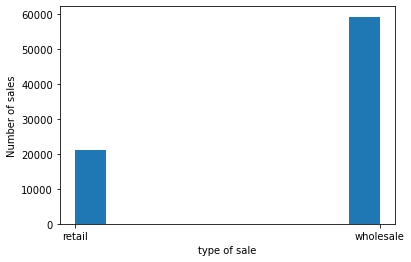

In [7]:
# Plot a histogram of "type of sale"
fig, ax = plt.subplots()
ax.hist(all_cars['type of sale'])
ax.set_xlabel("type of sale")
ax.set_ylabel("Number of sales")
plt.show()

Notes: It is interesting to compare the retail pricing model with the wholesale pricing model.

### 2.3 Select the retail data

In [8]:
# Select the retail data
car = all_cars[all_cars['type of sale']== 'retail']

In [9]:
# Rename the column names: replace space in the column names with '_'
car.columns = car.columns.str.replace(' ', '_')
# car.head();

In [10]:
# Drop the irrelevant index column 'Unnamed:_0' column
# Drop the specified label of 'type_of_sale' which is not a variable
car = car.drop(['Unnamed:_0','type_of_sale'], axis=1)

In [11]:
# Change the types
car = car.astype({'plant_nr': 'str', 'shipto_nr': 'str', 'soldto_nr': 'str'})
car.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21141 entries, 0 to 80003
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   booking_to_delivery_date  21141 non-null  object        
 1   unit_price($000)          21141 non-null  float64       
 2   date_of_sale              21141 non-null  datetime64[ns]
 3   mode_of_transport         21141 non-null  object        
 4   no_of_units               21141 non-null  float64       
 5   cust_group_name           21141 non-null  object        
 6   cust_segment_name         21129 non-null  object        
 7   Customer_Id               21141 non-null  object        
 8   delivery_month_from       21141 non-null  datetime64[ns]
 9   delivery_month_to         21141 non-null  datetime64[ns]
 10  type                      21141 non-null  object        
 11  item_class_l1             21141 non-null  object        
 12  item_class_l2     

Notes: the columns of 'plant_city', 'plant_country_name' , 'cust_segment_name', 'most_expensive_part_l1', 'most_expensive_part_l2' contains less than 0.1% of missing values, 'shipto_city' contain less than 0.41% of missing values. 

### 2.4 Exploratory Data Analysis(EDA) for the raw data

In [12]:
# EDA by pandas_profiling
# pp.ProfileReport(car)

In [13]:
# The errors observations estimation

# % of negative observations of 'no_of_units'
n1  = car['no_of_units'][car['no_of_units']<0].count()/car['no_of_units'].count()*100
pr1 = "Negative observations of 'no_of_units' = {:.2f} %".format(n1)
print(pr1)
# % of sum of negative observations of 'no_of_units' in the sum of the positive obseravtions
n1sum = car['no_of_units'][car['no_of_units']<0].sum()/car['no_of_units'][car['no_of_units']>=0].sum()*100
pr1sum = "Sum of negative observations of 'no_of_units' = {:.2f} %".format(n1sum)
print(pr1sum)
# % of negative observations of 'unit_price($000)'
n1zero = car['no_of_units'][car['no_of_units']==0].count()/car['no_of_units'].count()*100
pr1zero = "Observations of ZERO values in 'no_of_units' = {:.2f} %".format(n1zero)
print(pr1zero)
# % of negative observations of 'unit_price($000)'
n2  = car['unit_price($000)'][car['unit_price($000)']<0].count()/car['unit_price($000)'].count()*100
pr2 = "Negative observations of 'unit_price($000)' = {:.2f} %".format(n2)
print(pr2)
# % of sum of negative observations of 'unit_price($000)' in the sum of the positive obseravtions
n2sum = car['unit_price($000)'][car['unit_price($000)']<0].sum()/car['unit_price($000)'][car['unit_price($000)']>=0].sum()*100
pr2sum = "Sum of negative observations of 'unit_price($000)' = {:.2f} %".format(n2sum)
print(pr2sum)
# % of negative observations of 'unit_price($000)'
n2zero = car['unit_price($000)'][car['unit_price($000)']==0].count()/car['unit_price($000)'].count()*100
pr2zero = "Observations of ZERO values in 'unit_price($000)' = {:.2f} %".format(n2zero)
print(pr2zero)

Negative observations of 'no_of_units' = 1.38 %
Sum of negative observations of 'no_of_units' = -0.01 %
Observations of ZERO values in 'no_of_units' = 12.80 %
Negative observations of 'unit_price($000)' = 1.65 %
Sum of negative observations of 'unit_price($000)' = -0.54 %
Observations of ZERO values in 'unit_price($000)' = 6.43 %


The sum of the negative observations of 'unit_price($000)' and 'no_of_units' are -0.54%, and -0.01 %, respectively. Therefore, these errors are negligible and we will drop it in the next subsection.

### 2.5 Data cleaning for the current features

In [14]:
# Clean data: Select the positive value observations of 'unit_price($000)' and 'no_of_units'
condition = (car['unit_price($000)']> 0) & (car['no_of_units']> 0)
car = car[condition]
# car.info()

## 3. Derivative features based on the proposed hypotheses

### 3.1 Cars of different types

Cars of different types (as shown by item_class_l2 or item_class_l3- they are not sure which one) could have different pricing structures. These features are included.

### 3.2 Size of their past purchases in terms of volume or total spend

Pricing differs depending on size of customer (i.e size of their past purchases in terms of volume or total spend- they are not sure which one).

Therefore, we derive the feature of the cumulative sum of each customer's past purchase size and totol spend.

In [15]:
# Sort the data by ['Customer_Id','date_of_sale'] for later use
car.sort_values(by= ['Customer_Id','date_of_sale'], ascending= True, inplace = True)

In [16]:
# define a new column to save the totol spend of each sale
car['totol_spend'] = car['unit_price($000)']* car['no_of_units']

Calculate the cumulative sum of a customer's recent past purchase size and totol spend.

Note: it is more convenient to process it in SQL which I would prefer for some data preprocessing.

In [17]:
# define a function to calculate the k terms cumulative sum of a customer's past purchases.
def cal_past_size(df,col,col_sum, k):
    test1 = pd.DataFrame([])
    for x in df['Customer_Id'].unique():
        test = df[df['Customer_Id'] == x ][col].cumsum() - df[df['Customer_Id'] == x ][col].shift(k).cumsum()
        test = test.to_frame().rename(columns={col: col_sum})
        test1 = pd.concat([test1, test])
    return test1

Study the size of the cumulative sum of a customer's recent past purchase size and totol spend.

The cumulative sum size is used to estimate the size of the customer, when it is too large the number of invalid observations increases, so the sum size should be limited.

We investigated the size and find it is reasonable in the range 4 - 7. We set it to be 5 below.

In [18]:
# Select the cumulative sum size
sum_size = 5
df_past_size = cal_past_size(car, 'no_of_units', 'past_size', sum_size)
df_past_spend = cal_past_size(car, 'totol_spend', 'past_spend', sum_size)
# Add these two columns to the dataframe of the data
car = pd.concat([car, df_past_size, df_past_spend],axis = 1)
# car.describe()

### 3.3 Recent transactions vs old transactions

While pricing a car, recent transactions have higher influence on price than old transactions.
We derive the period of the transactions from the earlist date.

In [19]:
car['transaction_period'] = (car.date_of_sale - car.date_of_sale.min()) / pd.to_timedelta(1, unit='D')
# car.info();

### 3.4 The price that a customer last paid for a car

The price that a customer last paid for a car is an important factor in pricing.
We derive the last paid unit price for each customer.

In [20]:
# Use the sorted data by ['Customer_Id','date_of_sale'] then shift one row to get the last paid price
# Note there is one(the first) row of each customer is not correct yet.
car['last_paid_price'] = car['unit_price($000)'].shift(1)
# reset the index
car.reset_index(drop=True, inplace=True)
# Fix the problem in the first row of each customer(set them as np.nan)
for x in car.index[1:]:
        if (car.loc[x, 'Customer_Id'] != car.loc[x - 1 ,'Customer_Id']):
            car.loc[x, 'last_paid_price'] = np.nan

### 3.5 Add addtional feature of the delivery period

Add addtional feature of the delivery period based on 'delivery_month_to' and 'delivery_month_from'.

In [21]:
# Add addtional feature of the delivery period and transform it into 'float64' type.
car['delivery_period'] = (car.delivery_month_to - car.delivery_month_from) / pd.to_timedelta(1, unit='D')

## 4. Missing values and outliers

### 4.1 Filling the missing values

The missing values observations are all less than 0.5% in the total number of observations.

These are negligible and we fill them properly.

In [22]:
# Filling the catergrical missing values with their modes
car['cust_segment_name'] = car['cust_segment_name'].fillna(car['cust_segment_name'].mode()[0]) 
car['plant_city'] = car['plant_city'].fillna(car['plant_city'].mode()[0]) 
car['plant_country_name'] = car['plant_country_name'].fillna(car['plant_country_name'].mode()[0]) 
car['most_expensive_part_l1'] = car['most_expensive_part_l1'].fillna(car['most_expensive_part_l1'].mode()[0]) 
car['most_expensive_part_l2'] = car['most_expensive_part_l2'].fillna(car['most_expensive_part_l2'].mode()[0]) 
car['shipto_city'] = car['shipto_city'].fillna(car['shipto_city'].mode()[0]) 
# Filling the missing values for the last paid price with zeros
car['last_paid_price'] = car['last_paid_price'].fillna(0)
car['past_size'] = car['past_size'].fillna(0) 
car['past_spend'] = car['past_spend'].fillna(0) 

### 4.2 Excluding the outliers

In [23]:
categorical_cols = car.select_dtypes(include=['object']).columns
numerical_cols = car.select_dtypes(include=['float64']).columns
datetime_cols = car.select_dtypes(include=['datetime64[ns]']).columns

In [24]:
# Excluding the outliers

In [25]:
# Check the skew of numerical features
car[numerical_cols].skew()

unit_price($000)      37.464393
no_of_units            6.489932
totol_spend            5.402567
past_size              2.976835
past_spend             5.714294
transaction_period    -0.417812
last_paid_price        2.972082
delivery_period        1.193607
dtype: float64

In [26]:
# Excluding the outliers using quantiles
no_out_cond = (car['unit_price($000)']<= car['unit_price($000)'].quantile(0.998)) &(car['no_of_units']<= car['no_of_units'].quantile(0.985)) & (car['totol_spend']<= car['totol_spend'].quantile(0.99)) & (car['past_spend']<= car['past_spend'].quantile(0.99)) & (car['last_paid_price']<= car['last_paid_price'].quantile(0.988))
car_no_out = car[no_out_cond]

In [27]:
# Drop the datetime64[ns] columns
car_no_out = car_no_out.drop(datetime_cols, axis=1)

In [28]:
# Check the skewnesses of numerical features after droping the outliers
# All the skewnesses are less than 3
car_no_out[numerical_cols].skew()

unit_price($000)      2.181523
no_of_units           2.306402
totol_spend           2.877967
past_size             2.716588
past_spend            2.714620
transaction_period   -0.405119
last_paid_price       2.079269
delivery_period       1.201860
dtype: float64

The data preprocessing is completed. The next section we will process the exploratory data analysis.

## 5. Exploratory Data Analysis(EDA)

### 5.1 EDA for categorical features

In [29]:
# Define the dataframes to select categorical or numerical features for EDA process
num_cols = list(numerical_cols)
cat_cols = list(categorical_cols)
cat_cols.append('unit_price($000)')
car_num = car_no_out[num_cols]
car_cat = car_no_out[cat_cols]

In [30]:
# Apply the EDA for categorical features
# pp.ProfileReport(car_cat)

High cardinality categorical features ['cust_group_name', 'Customer_Id', 'shipto_city' ,'shipto_nr', 'soldto_city', 'car_nr'] are identified.

We will make botplots and histogrms of them in the next step.

In [31]:
# Define a function to plot botplots and histogrms.
def cat_plt(df, col):
    plt.figure(figsize=(18,7))

    plt.subplot(1,2,1)
    plt.title(col + 'vs unit_price($000)')
    sns.countplot(car_cat[col], palette=("cubehelix"))

    plt.subplot(1,2,2)
    plt.title(col + ' vs unit_price($000)')
    sns.boxplot(x = df[col], y= df['unit_price($000)'], palette=("cubehelix"))
    plt.show()

In [32]:
# High cardinality categorical features
cat_neglect = ['cust_group_name', 'Customer_Id', 'shipto_city' ,'shipto_nr', 'soldto_city', 'car_nr']

# Low cardinality categorical features
cat_lefted = ['booking_to_delivery_date', 'mode_of_transport', 'cust_segment_name', 'type', 'item_class_l1', 
 'item_class_l2', 'item_class_l3', 'colour', 'plant_nr', 'plant_city', 'plant_country_name', 'most_expensive_part_l1',
 'most_expensive_part_l2', 'soldto_nr', 'shipto_country', 'soldto_country']

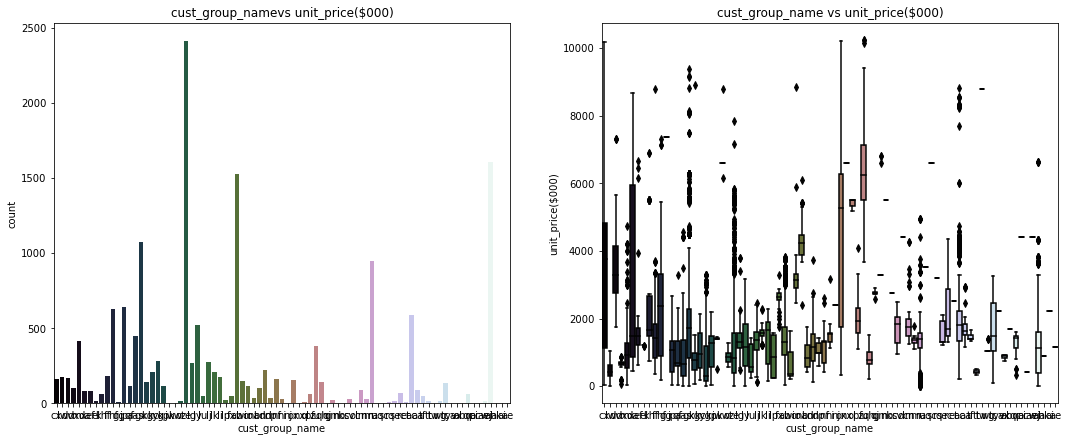

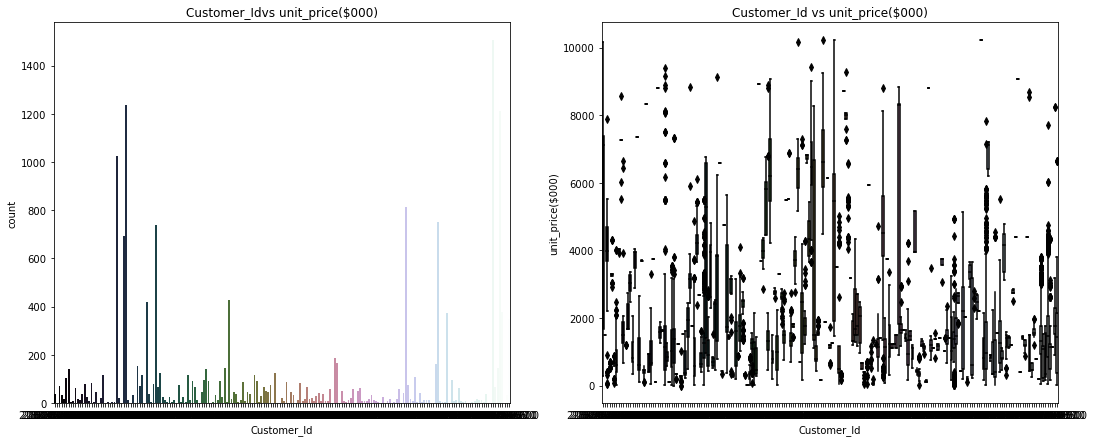

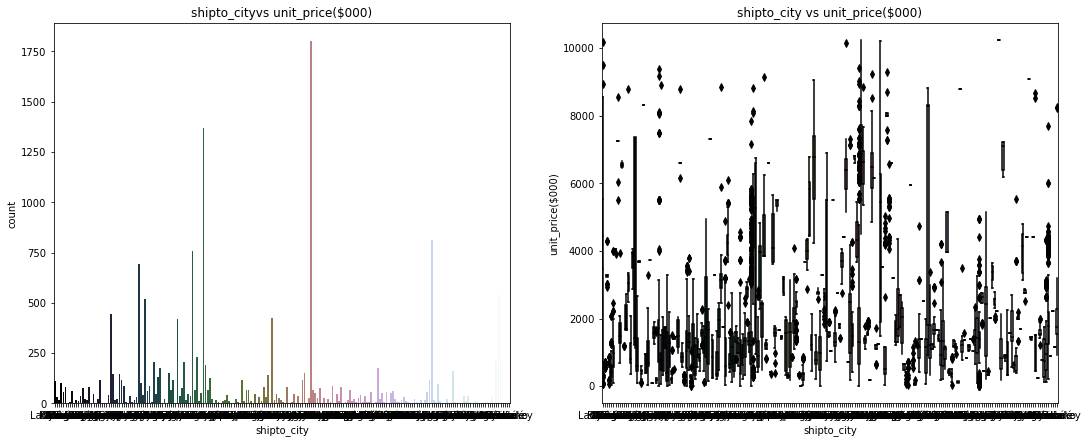

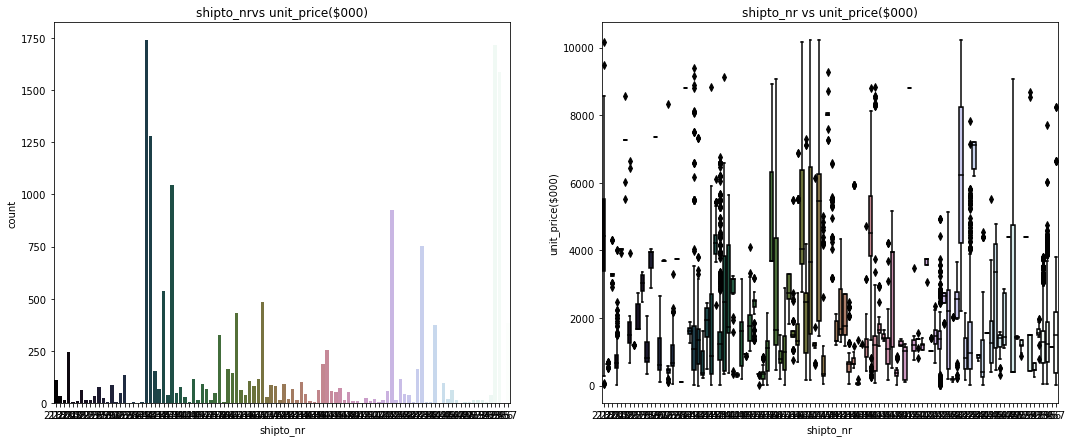

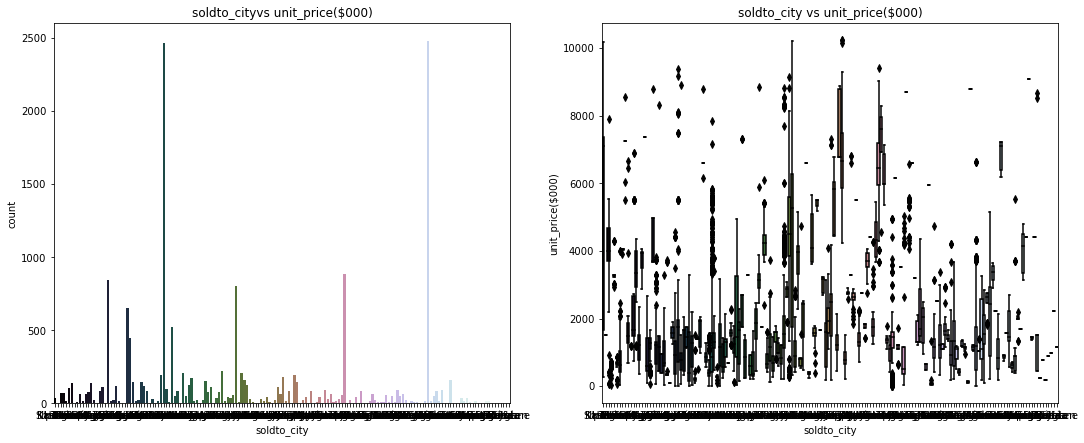

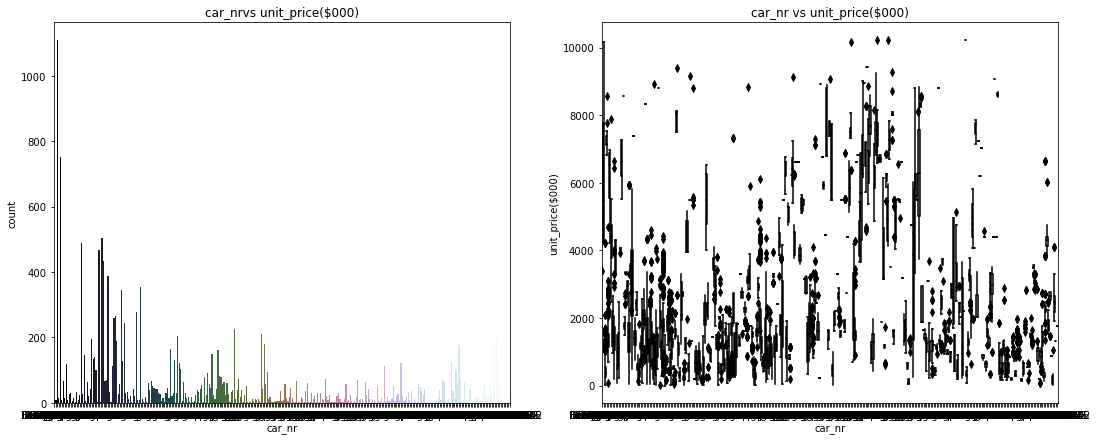

In [33]:
# Plot the categorical features with large number of categories (high cardinality)
for x in cat_neglect:
    cat_plt(car_cat,x)

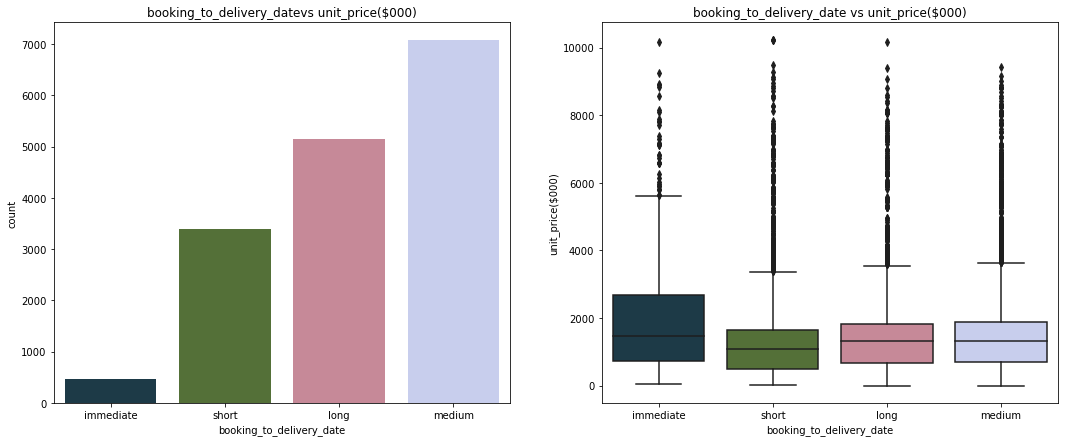

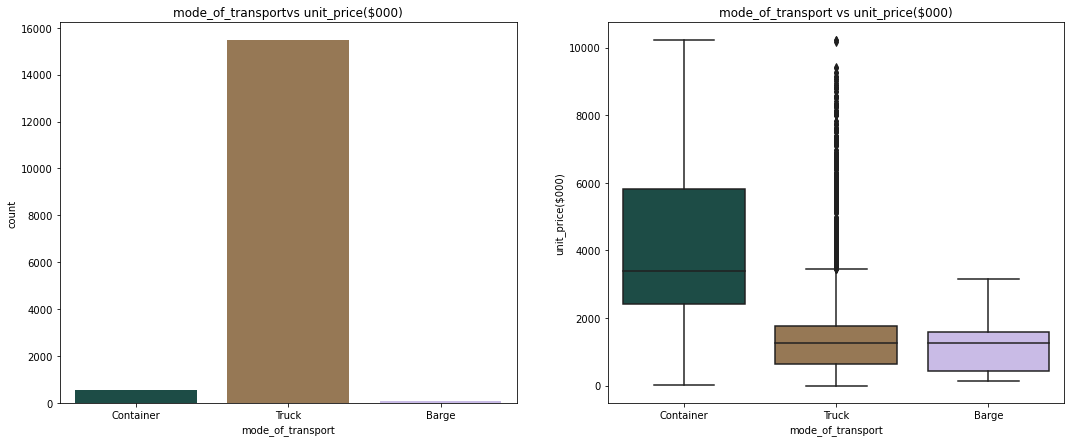

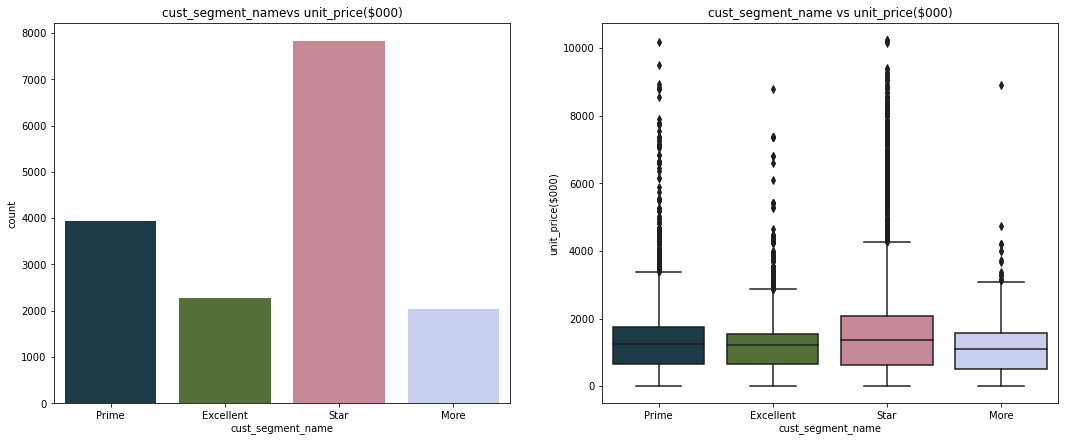

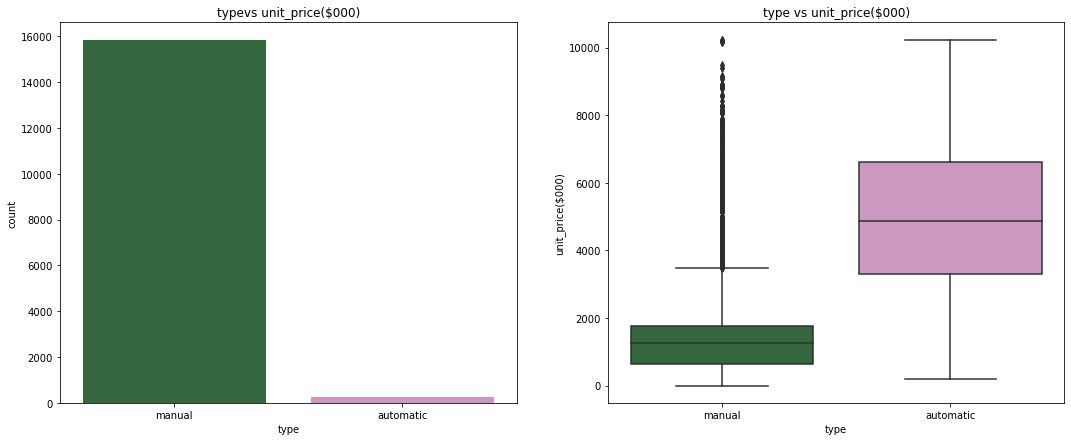

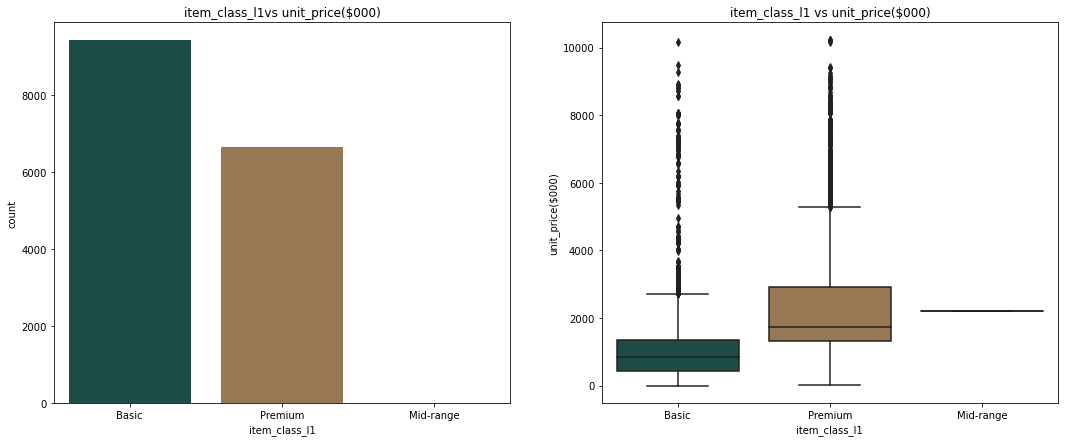

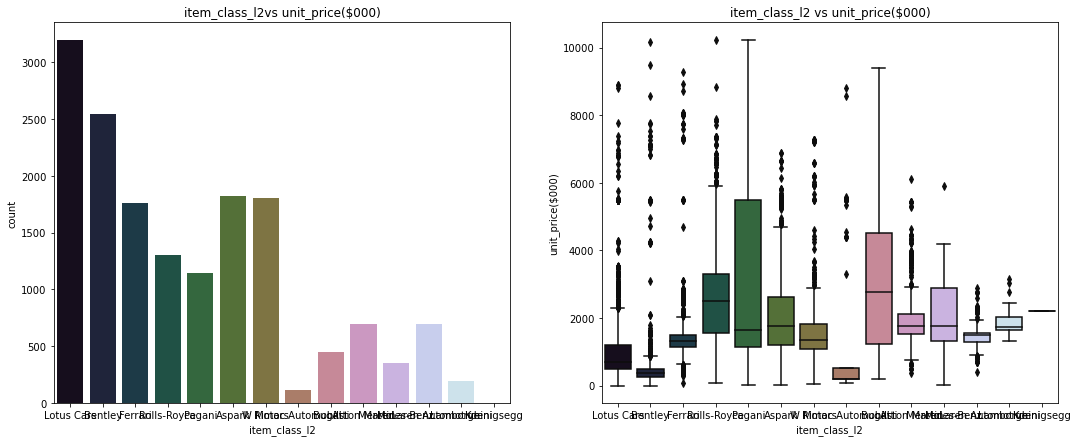

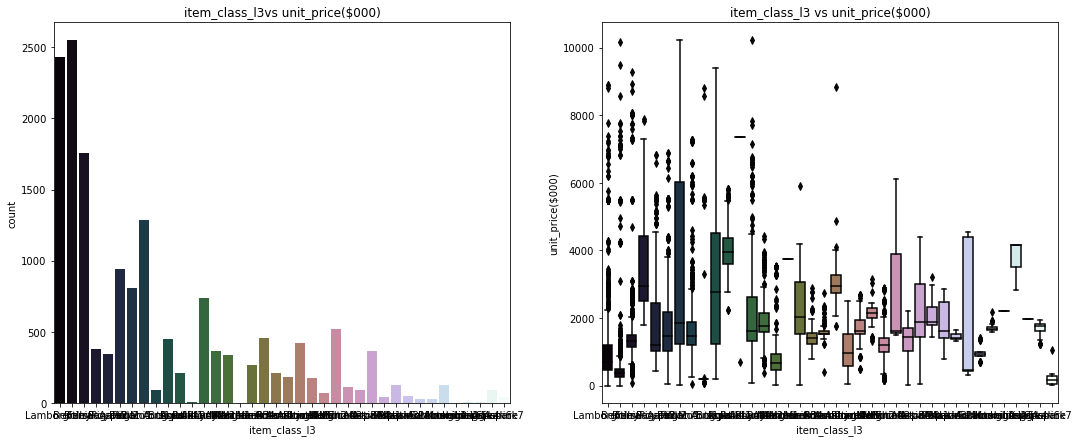

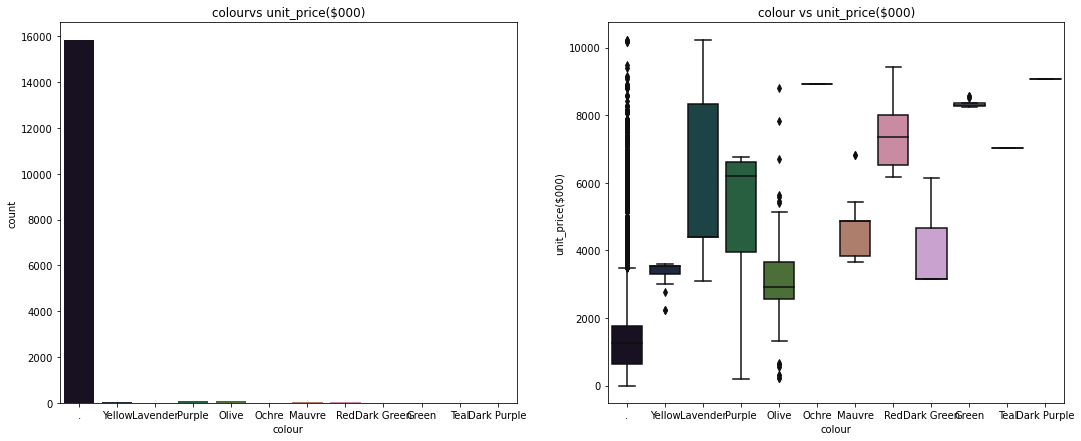

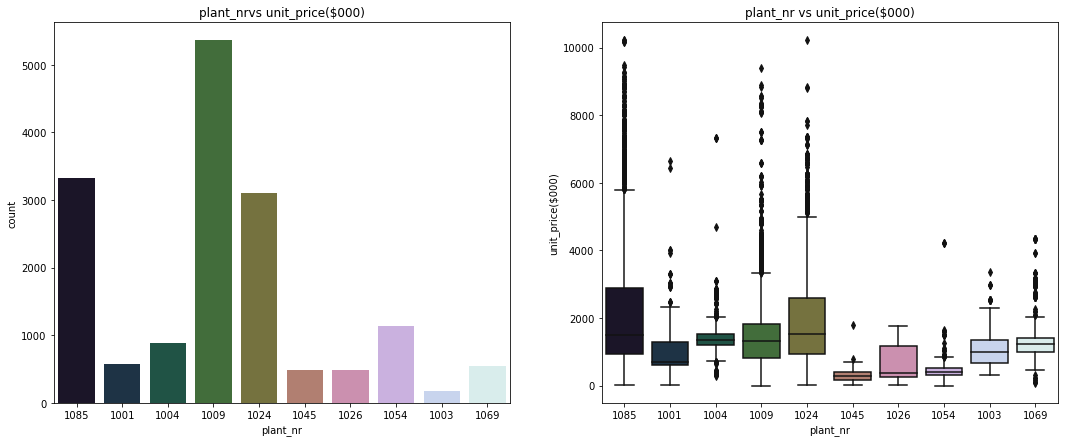

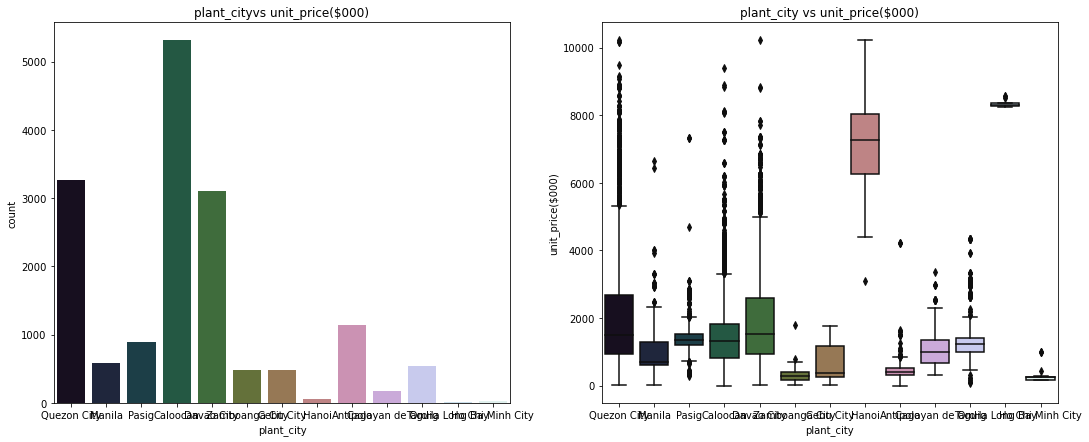

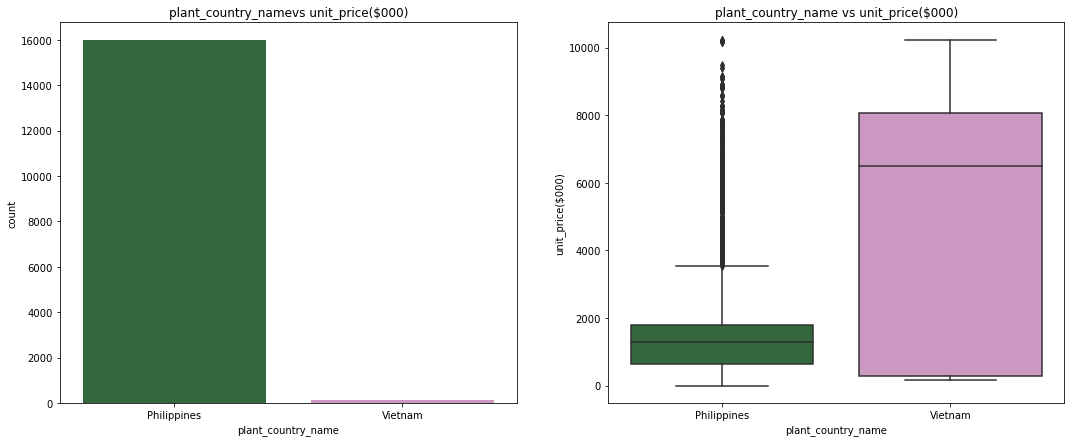

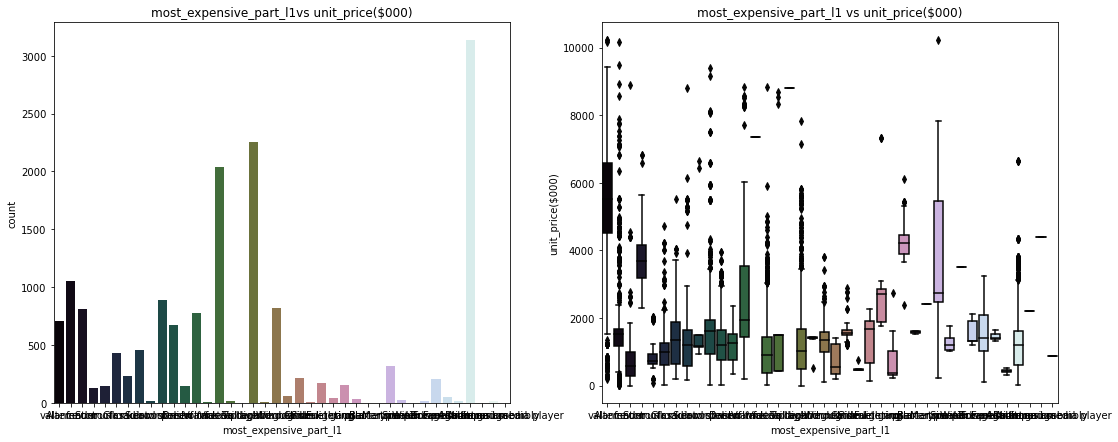

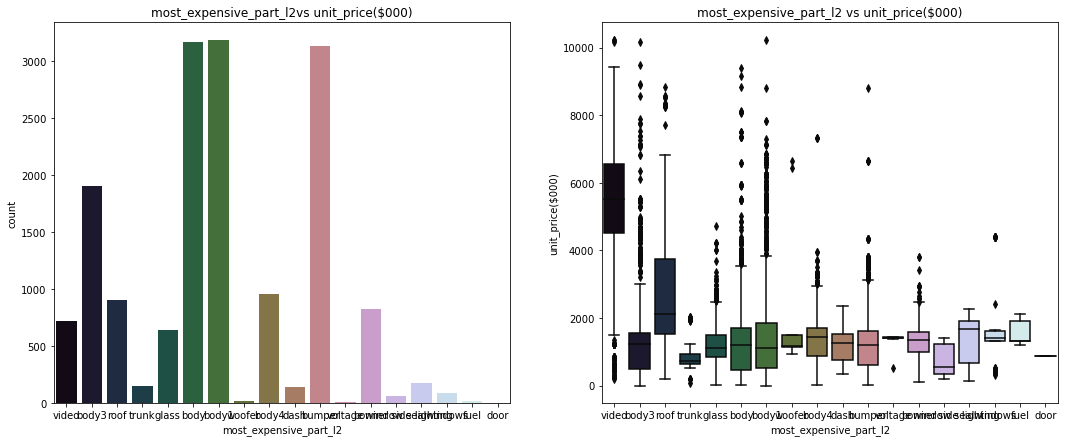

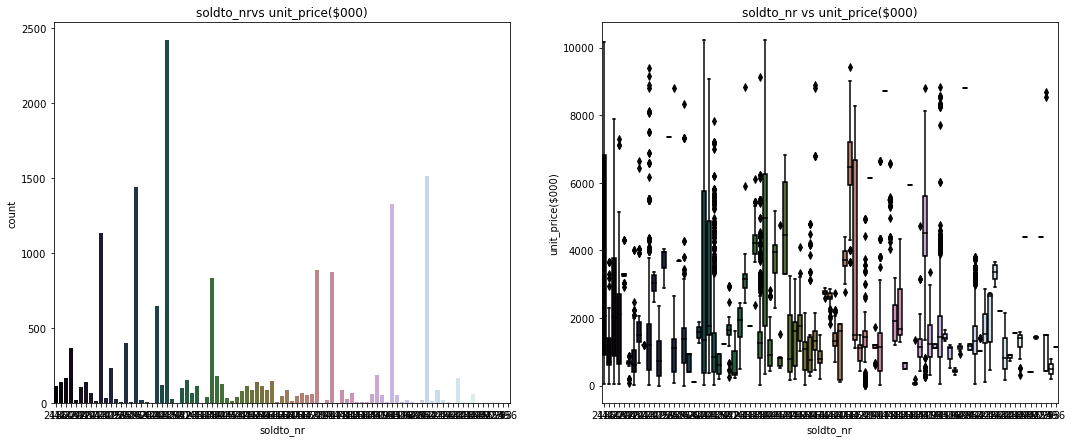

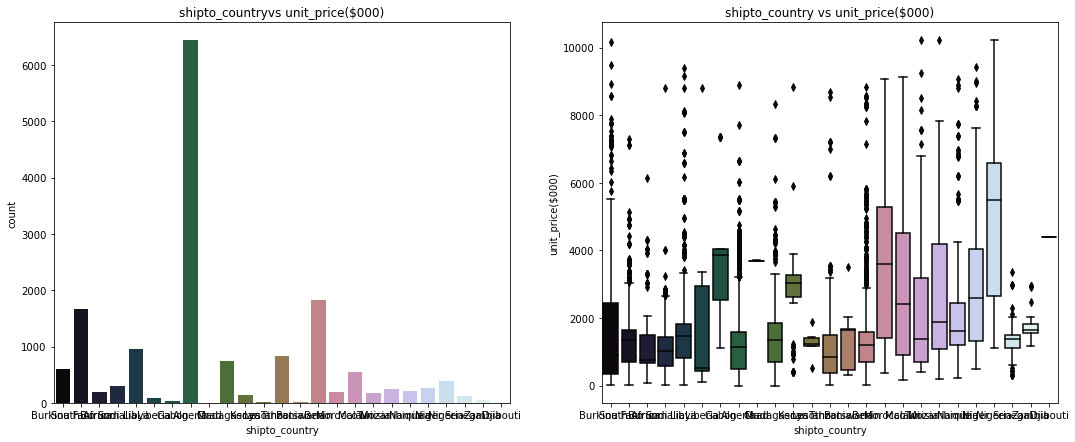

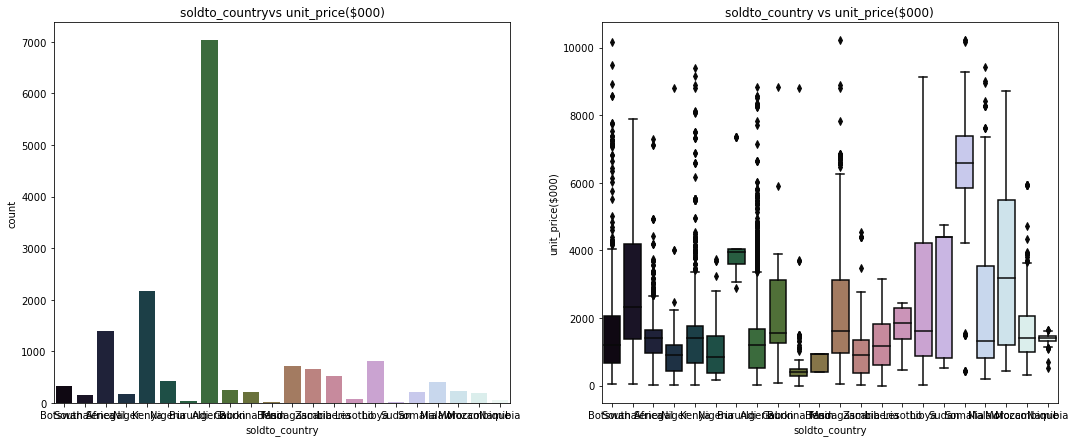

In [34]:
# Plot the categorical features with small number of categories(low cardinality)
for x in cat_lefted:
    cat_plt(car_cat,x)

From the valulization, the 'item_class_l1', 'item_class_l2', 'item_class_l3' show some impact in price difference in their different categories.

### 5.2 EDA for numerical features

In [35]:
# Apply the EDA for numerical features
# pp.ProfileReport(car_num)

### 5.3 EDA for all features

In [36]:
# Apply the EDA for all features
# pp.ProfileReport(car_no_out)

### 5.4 Crrelations analysis

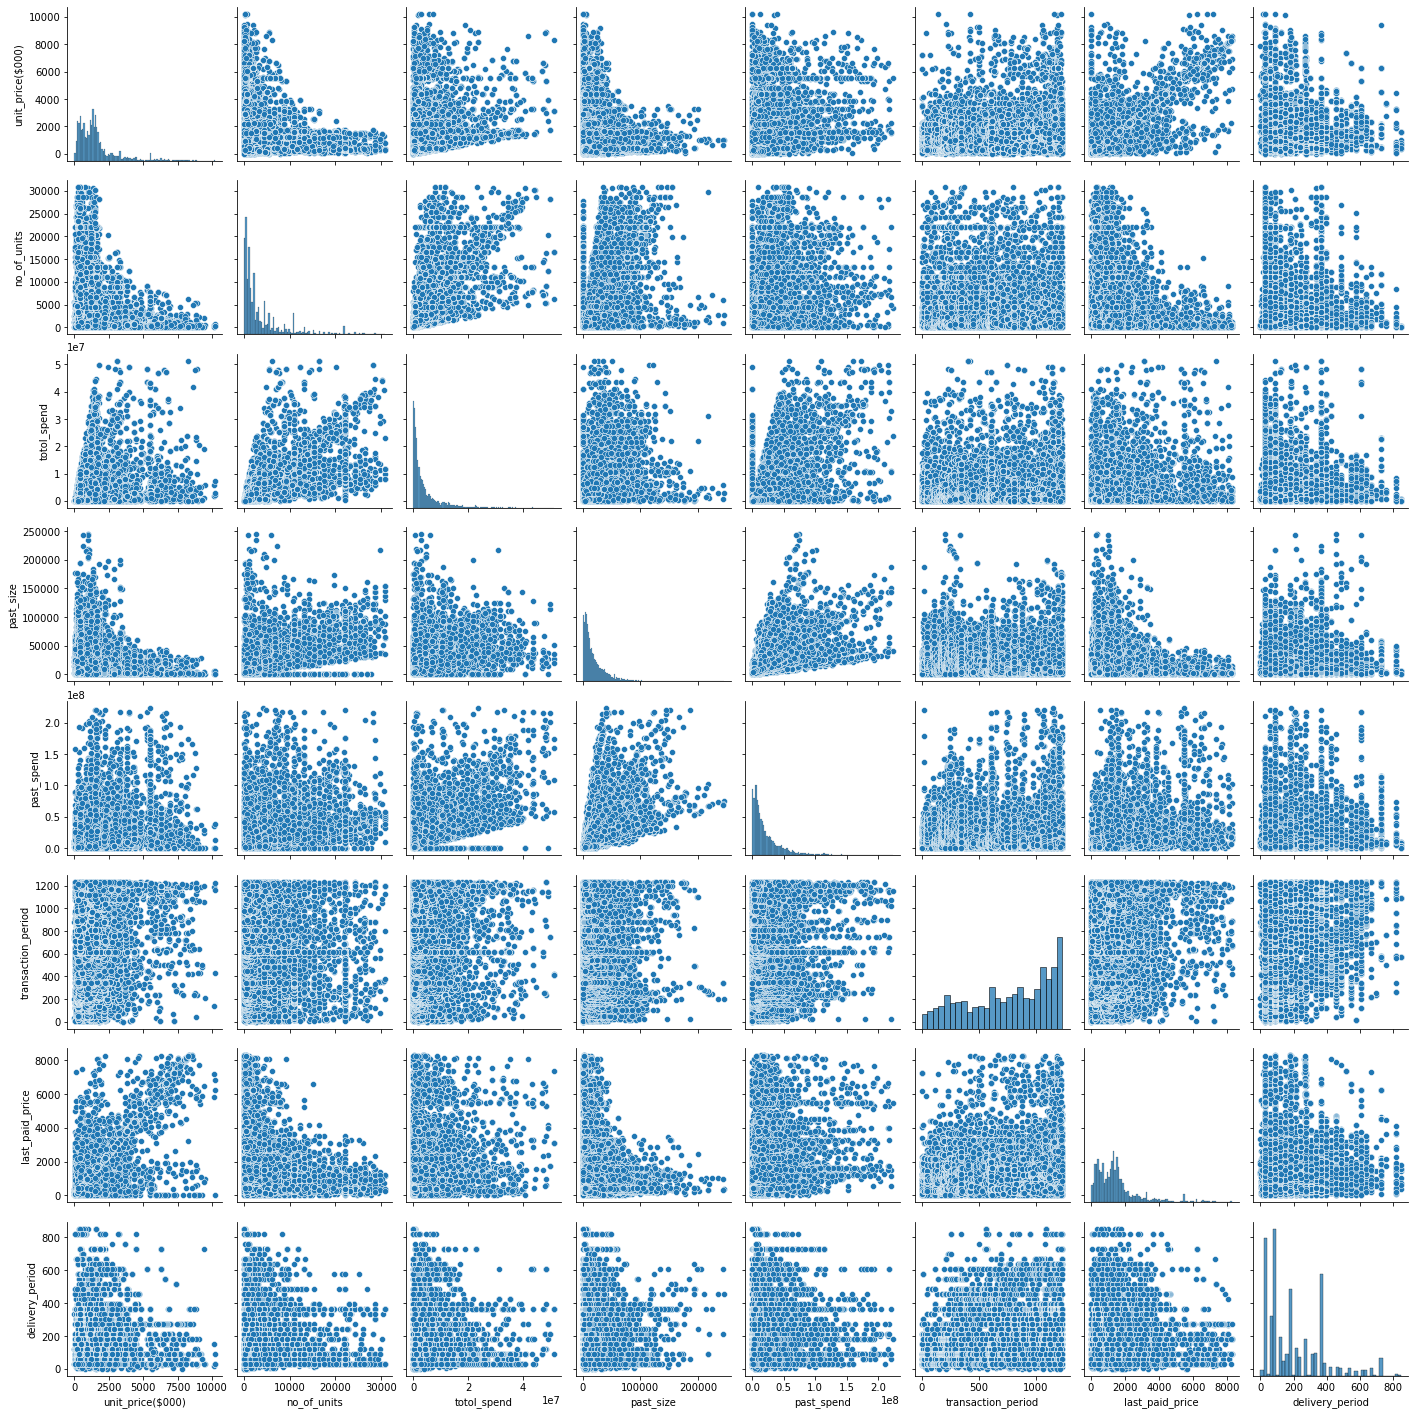

In [37]:
# Pair plot of numerical features to visualize the correlations
ax = sns.pairplot(car_no_out[num_cols])

In [38]:
# Correlation of the numerical features and the target price
car_no_out[num_cols].corr()

unit_price($000)  no_of_units  totol_spend  past_size  \
unit_price($000)            1.000000    -0.218193     0.254028  -0.186189   
no_of_units                -0.218193     1.000000     0.646713   0.578494   
totol_spend                 0.254028     0.646713     1.000000   0.365475   
past_size                  -0.186189     0.578494     0.365475   1.000000   
past_spend                  0.229209     0.390708     0.647784   0.637403   
transaction_period          0.134364    -0.086073     0.015552  -0.078410   
last_paid_price             0.797173    -0.178820     0.208619  -0.190959   
delivery_period             0.052836    -0.097731     0.000486  -0.052871   

                    past_spend  transaction_period  last_paid_price  \
unit_price($000)      0.229209            0.134364         0.797173   
no_of_units           0.390708           -0.086073        -0.178820   
totol_spend           0.647784            0.015552         0.208619   
past_size             0.637403           -0.078410        -0.190959   
past_spend            1.000000            0.051838         0.255831   
transaction_period    0.051838            1.000000         0.150590   
last_paid_price       0.255831            0.150590         1.000000   
delivery_period       0.025324            0.226934         0.070089   

                    delivery_period  
unit_price($000)           0.052836  
no_of_units               -0.097731  
totol_spend                0.000486  
past_size                 -0.052871  
past_spend                 0.025324  
transaction_period         0.226934  
last_paid_price            0.070089  
delivery_period            1.000000

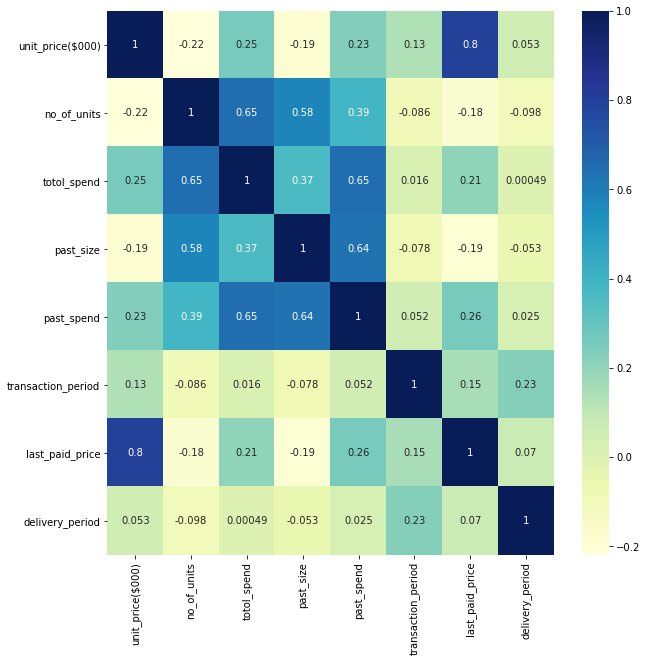

In [39]:
# Correlation using heatmap to visualize
plt.figure(figsize = (10, 10))
sns.heatmap(car_no_out[num_cols].corr(), annot = True, cmap="YlGnBu")
plt.show()

The correlations between variables show:

(1). There is a significant positive correlation between the unit price and the last paid price that is 0.8.

(2). There are postive correlations between 'unit_price$(000)' and 'last_paid_price', 'totol_spend', 'past_spend' and 'transaction_period'.

(3). Negative correlations between 'unit_price$(000)' and 'no_of_units' and 'past_size' are observed.

(4). There are postive correlations between 'past_spend' and 'totol_spend', 'past_size'.

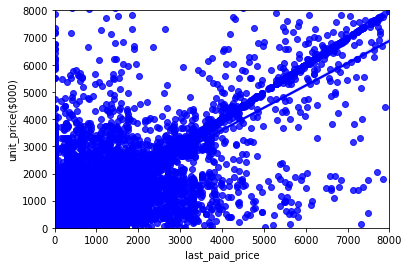

In [40]:
# Show a scatter plot of the last paid price and the unit price.
sns.regplot(x= 'last_paid_price', y='unit_price($000)' ,data= car_no_out[num_cols],color='b')
plt.xlim([0, 8000])
plt.ylim([0, 8000])
plt.show()

There is a strong indication for a linear relation, especially in the large last paid price region from the scatter plot.

## 6. Machine learning models

Because there is a significant correlation between the target 'unit_price($000)' and the 'last_paid_price' that is 0.8, it is reasonable to build a model only contains numerical features firstly then consider models with relevent categorical features.

### 6.1 Linear regression models with only numerical features

In [41]:
# Define a function to rescale the data with MinMaxScaler
def rescale(df):
    scaler = MinMaxScaler()
    df[df.columns] = scaler.fit_transform(df[df.columns])

In [42]:
# Define a function to bulid ML model and present the results
def lr_func(model, df, weight_k, coef, bins, bag):
    
    # Train-Test spliting
    np.random.seed(0)
    df_train, df_test = train_test_split(df, train_size = 0.7, test_size = 0.3, random_state = 10)
    # Dividing data into X and y variables
    y_train = df_train.pop('unit_price($000)')
    X_train = df_train
    y_test = df_test.pop('unit_price($000)')
    X_test = df_test
    
    # Adding a weight which decays exponentially based on the transaction period
    weight = X_train.transaction_period.array- 1
    sample_weight = np.exp(weight_k * weight)
    
    # Select BaggingRegressor if needed
    if bag == True:
        # BaggingRegressor with a base estimator
        lr = BaggingRegressor(base_estimator= model, n_estimators= 3, random_state= 10)
    else:
        lr = model
    
    # Train the model     
    lr.fit(X_train,y_train, sample_weight)
    y_train_pred = lr.predict(X_train)
    y_test_pred = lr.predict(X_test)
    
    # Testing set R2 Accuracy
    print('Test set Accuracy R2: {:.3f}'.format(lr.score(X_test,y_test)))
    # Training set MSE
    print('Train set RMSE: {:.3f}'.format(np.sqrt(MSE(y_train, y_train_pred))))
    # Testing set MSE
    print('Test set RMSE: {:.3f}'.format(np.sqrt(MSE(y_test, y_test_pred))))
    # Training set CV scores
    print('Training set CV scores mean: {:.3f}'.format(np.mean(cross_val_score(lr, X_train, y_train, cv = 5))))
    print('Training set CV scores: {:}'.format(cross_val_score(lr, X_train, y_train, cv = 5)))
    
    # Total revenue generated by your model vs the actual revenue
    total_revenue_pred = (y_test_pred* X_test.no_of_units).sum()
    total_revenue_actu = (y_test* X_test.no_of_units).sum()
    re_per = (total_revenue_pred - total_revenue_actu)/total_revenue_actu*100
    print('% of total revenue generated by the model vs the actual revenue: {:.2f} %'.format(re_per))
    
    # Select to present the coefficients of linear regression    
    if bag == False and coef == True:
        print(lr.coef_)
        print(lr.intercept_)
    
    # Vasualization of the prediction vs actual price
    per_test_pred_act = (y_test_pred -y_test)/y_test_pred *100
    
    # Create a figure with subplots to show the results
    plt.figure(figsize=(18,7))
    plt.subplot(1,2,1)
    # Plot a histogram to present % of total revenue generated by the model vs the actual revenue     
    sns.distplot(per_test_pred_act,bins = bins, hist= True, color='g',norm_hist= True, kde = False)
    plt.xlim(-150, 150)
    plt.xlabel('% of the difference between the y_test_pred and the y_test')
    plt.ylabel('Probability')
    plt.title('Histogram of % of the difference for '+ str(model))

    plt.subplot(1,2,2)
    # Scatter plot to show the predicted price and the actual price for the test set 
    plt.scatter(y_test, y_test_pred)
    # Plot y = x line to compare the results     
    x = np.linspace(0, 1, 1000)
    plt.plot(x, x, color = 'pink');
    plt.title('y_test_pred vs y_test for '+ str(model))           
    plt.xlabel('y_test') 
    plt.ylabel('y_test_pred')
    plt.show()

In [43]:
# Rescale the numericial features and the target variable
rescale(car_num)
# Check if the data is rescaled properly before training the models
car_num.describe()

unit_price($000)   no_of_units   totol_spend     past_size  \
count      16084.000000  16084.000000  16084.000000  16084.000000   
mean           0.154661      0.128641      0.090279      0.085666   
std            0.140080      0.170864      0.129789      0.099873   
min            0.000000      0.000000      0.000000      0.000000   
25%            0.063262      0.021415      0.015117      0.022533   
50%            0.125266      0.059513      0.039857      0.051374   
75%            0.178264      0.159988      0.109133      0.112663   
max            1.000000      1.000000      1.000000      1.000000   

         past_spend  transaction_period  last_paid_price  delivery_period  
count  16084.000000        16084.000000     16084.000000     16084.000000  
mean       0.105196            0.611287         0.185993         0.240771  
std        0.125575            0.293113         0.167770         0.202527  
min        0.000000            0.000000         0.000000         0.000000  
25%        0.027687            0.369231         0.075448         0.104460  
50%        0.061962            0.662348         0.151668         0.178404  
75%        0.135308            0.874494         0.216660         0.390845  
max        1.000000            1.000000         1.000000         1.000000

Train the linear regression model and present the results.

Test set Accuracy R2: 0.720
Train set RMSE: 0.080
Test set RMSE: 0.074
Training set CV scores mean: 0.671
Training set CV scores: [0.62374901 0.6821978  0.71300583 0.63164967 0.70575964]
% of total revenue generated by the model vs the actual revenue: 0.96 %


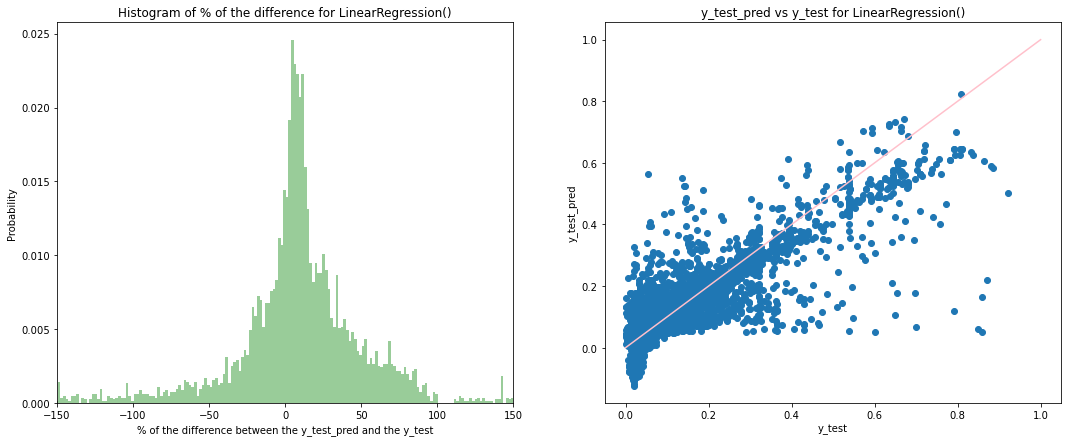

In [44]:
# Apply the machine learning model function of LinearRegression() for only the numerical features and present the results
lr_func(LinearRegression(), car_num, 0, True, 4000, True)

The linear regression model without tuning the hyperparameters shows a good accuracy(0.720) and a low root of mean squared error(0.074).

And the % of total revenue generated by the model vs the actual revenue is 0.96 %

From the left figure of the % difference, we observe that the error distribution has a mean around zero and mainly located in the range (-100, 100). 

From the right figure of the test unit price vs the predition, there is significant contribution(with large number of observations) for the errors in the small test unit price region. This indicates that the current linear regression model doesn't represent the low test unit price features good enough. We will consider to include categorical features in the following sections.

Train the Ridge model and present the results.

Test set Accuracy R2: 0.720
Train set RMSE: 0.080
Test set RMSE: 0.074
Training set CV scores mean: 0.671
Training set CV scores: [0.62369227 0.68215527 0.71293955 0.63150244 0.70602208]
% of total revenue generated by the model vs the actual revenue: 1.02 %


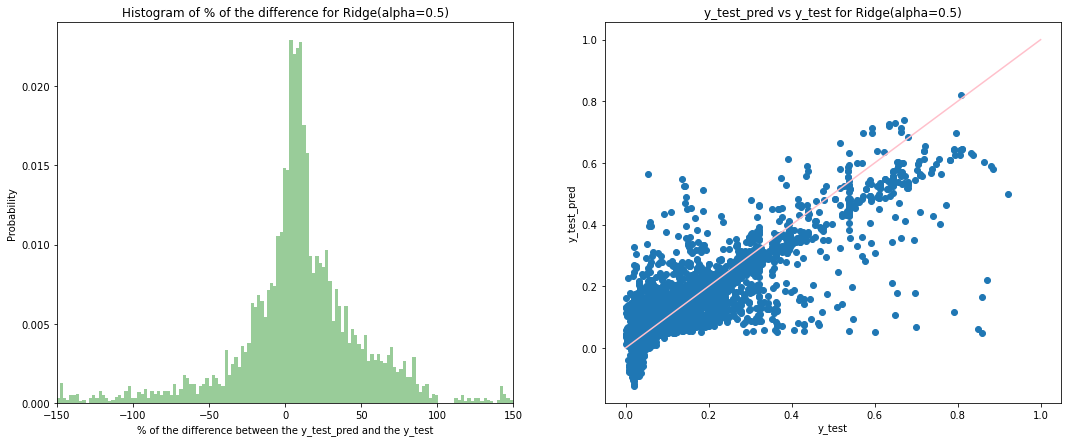

In [45]:
# Apply the machine learning model function of Ridge(alpha= 1) for only the numerical features and present the results
lr_func(Ridge(alpha= 0.5), car_num, 0, True, 4000, True)

The Ridge model( with alpha = 0.5) without tuning the hyperparameters shows a good accuracy(0.720) and a low root of mean squared error(0.074).

And the % of total revenue generated by the model vs the actual revenue is 1.02 %

From the left figure of the % difference, we observe that the error distribution has a mean around zero and mainly located in the range (-100, 100). 

From the right figure of the test unit price vs the predition, there is significant contribution(with large number of observations) for the errors in the small test unit price region. This indicates that the current linear regression model doesn't represent the low test unit price features good enough. We will consider to include categorical features in the following sections.

### 6.2 Linear regression models with categorical features

#### 6.2.1 Model with dummy variables for 'item_class_l2'

In [46]:
# Defining the map function to creat dummies
def dummies(x,df):
    temp = pd.get_dummies(df[x], drop_first = True, prefix= x)
    df = pd.concat([df, 1000*temp], axis = 1)
    df.drop([x], axis = 1, inplace = True)
    return df

In [47]:
# Preparing to add dummy variable for 'item_class_l2'
num_cols_l2 = ['unit_price($000)', 'no_of_units', 'totol_spend', 'past_size', 'past_spend', 'transaction_period', 
             'last_paid_price', 'delivery_period','item_class_l2']
car_l2 = car_no_out[num_cols_l2]

In [48]:
# Applying the function to add dummy variable for 'item_class_l2'
car_l2 = dummies('item_class_l2',car_l2)

In [49]:
# Rescaling of the input features with MinMaxScaler
rescale(car_l2)
# Check the rescaling
# car_l2.describe()

Test set Accuracy R2: 0.743
Train set RMSE: 0.076
Test set RMSE: 0.071
Training set CV scores mean: 0.702
Training set CV scores: [0.65457012 0.72053113 0.73510039 0.66803816 0.73281337]
% of total revenue generated by the model vs the actual revenue: 1.16 %


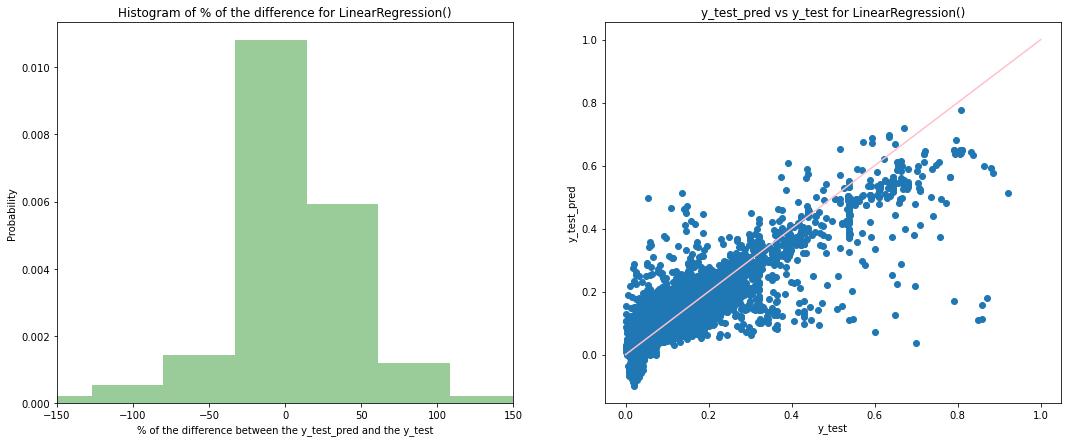

In [50]:
# Apply the machine learning model function of LinearRegression() for include 'item_class_l2' dummy variables and present the results
lr_func(LinearRegression(), car_l2, 0, False, 5000, True)

The linear regression model(weight_k = 0) without tuning the hyperparameters shows a good accuracy(0.743) and a low root of mean squared error(0.071).

And the % of total revenue generated by the model vs the actual revenue is 1.16 %

From the left figure of the % difference, we observe that the error distribution has a mean around zero and mainly located in the range (-100, 100). 

From the right figure of the test unit price vs the predition, there is significant contribution(with large number of observations) for the errors in the small test unit price region. This indicates that the current linear regression model doesn't represent the low test unit price features good enough. We will consider to include categorical features in the following sections.

In [51]:
# car_l2.describe()

Test set Accuracy R2: 0.742
Train set RMSE: 0.076
Test set RMSE: 0.071
Training set CV scores mean: 0.703
Training set CV scores: [0.65501601 0.72126189 0.73412831 0.66859652 0.73350851]
% of total revenue generated by the model vs the actual revenue: 0.82 %


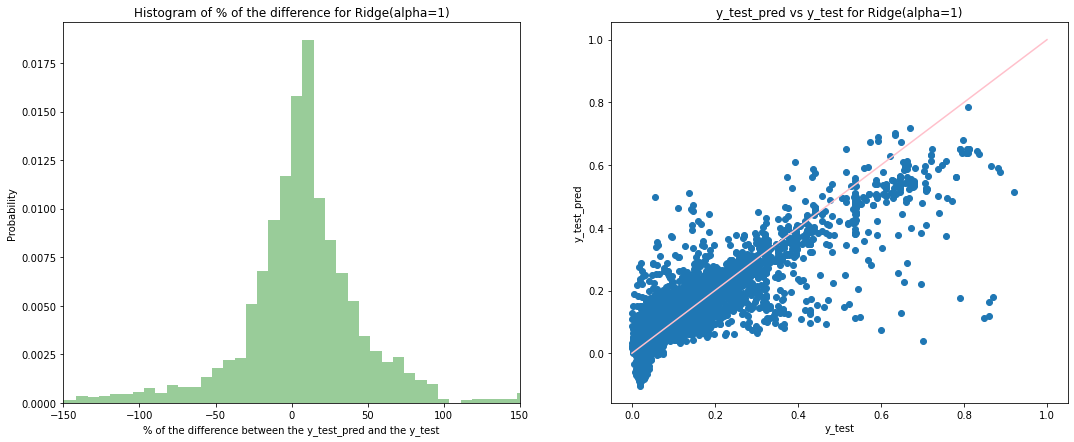

In [52]:
# Apply the machine learning model function of Ridge(alpha = 1) including 'item_class_l2' dummy variables and present the results
lr_func(Ridge(alpha = 1), car_l2, 0, False, 4000, False)

The Ridge model(alpha = 1) without tuning the hyperparameters shows a good accuracy(0.742) and a low root of mean squared error(0.071).

And the % of total revenue generated by the model vs the actual revenue is 0.82 %.

From the left figure of the % difference, we observe that the error distribution has a mean around zero and mainly located in the range (-100, 100). 

From the right figure of the test unit price vs the predition, there is significant contribution(with large number of observations) for the errors in the small test unit price region. This indicates that the current linear regression model doesn't represent the low test unit price features good enough. We will consider to include categorical features in the following sections.

#### 6.2.2 Model with dummy variables for 'item_class_l3'

In [53]:
# Preparing to add dummy variable for 'item_class_l3'
num_cols_l3 = ['unit_price($000)', 'no_of_units', 'totol_spend', 'past_size', 'past_spend', 'transaction_period', 
             'last_paid_price', 'delivery_period','item_class_l3']
car_l3 = car_no_out[num_cols_l3]

In [54]:
# Applying the function to add dummy variables for 'item_class_l3'
car_l3 = dummies('item_class_l3',car_l3)

In [55]:
# Rescaling of the input features with MinMaxScaler
rescale(car_l3)
# car_l3.describe()

Test set Accuracy R2: 0.749
Train set RMSE: 0.074
Test set RMSE: 0.070
Training set CV scores mean: 0.715
Training set CV scores: [0.67086311 0.73185898 0.74333047 0.68521874 0.74598216]
% of total revenue generated by the model vs the actual revenue: 0.41 %


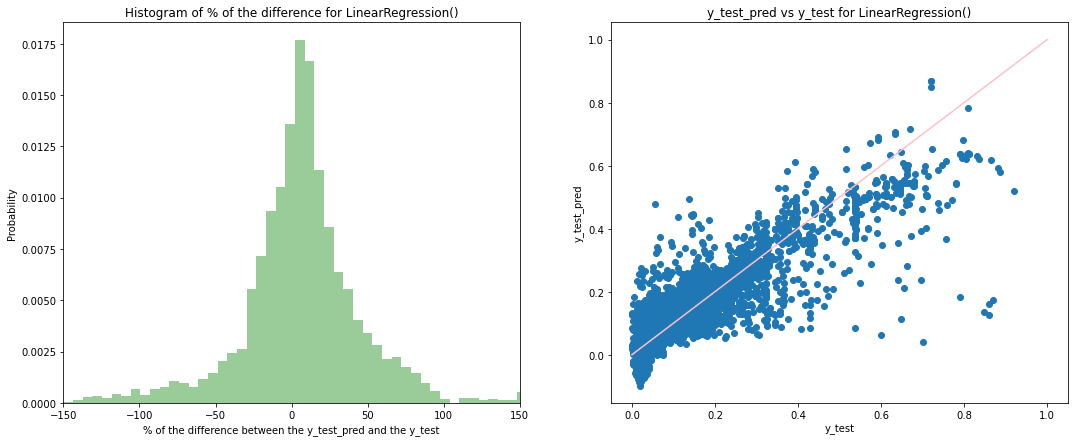

In [56]:
# Apply the machine learning model function of LinearRegression() including 'item_class_l3' dummy variables and present the results
lr_func(LinearRegression(), car_l3, 0, False, 4000, False)

The linear regression model without tuning the hyperparameters shows a good accuracy(0.749) and a low root of mean squared error(0.070).

And the % of total revenue generated by the model vs the actual revenue is 0.41 %.

From the left figure of the % difference, we observe that the error distribution has a mean around zero and mainly located in the range (-100, 100). 

From the right figure of the test unit price vs the predition, there is significant contribution(with large number of observations) for the errors in the small test unit price region. This indicates that the current linear regression model doesn't represent the low test unit price features good enough. We will consider to include categorical features in the following sections.

Test set Accuracy R2: 0.750
Train set RMSE: 0.074
Test set RMSE: 0.070
Training set CV scores mean: 0.715
Training set CV scores: [0.66976197 0.73232748 0.74272384 0.68422057 0.74619842]
% of total revenue generated by the model vs the actual revenue: 0.49 %


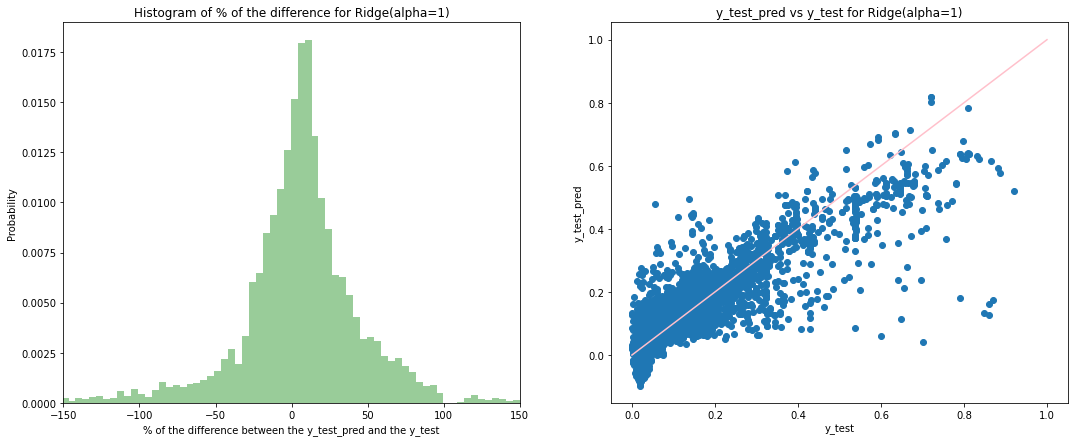

In [57]:
# Apply the machine learning model function of Ridge(alpha = 1) including 'item_class_l3' dummy variables and present the results
lr_func(Ridge(alpha = 1), car_l3, 0, False, 4000, False)

The Ridge model(alpha = 1) without tuning the hyperparameters shows a good accuracy(0.750) and a low root of mean squared error(0.070).

And the % of total revenue generated by the model vs the actual revenue is 0.49 %.

From the left figure of the % difference, we observe that the error distribution has a mean around zero and mainly located in the range (-100, 100). 

From the right figure of the test unit price vs the predition, there is significant contribution(with large number of observations) for the errors in the small test unit price region. This indicates that the current linear regression model doesn't represent the low test unit price features good enough. We will consider to include more categorical features in the following sections.

#### 6.2.3 Building model with dummy variables for 'item_class_l2' and 'item_class_l3'

In [58]:
# Preparing to add dummy variables for 'item_class_l2' and 'item_class_l3'
num_cols_both = ['unit_price($000)', 'no_of_units', 'totol_spend', 'past_size', 'past_spend', 'transaction_period', 
             'last_paid_price', 'delivery_period','item_class_l2', 'item_class_l3']
car_both = car_no_out[num_cols_both]

In [59]:
# Applying the function
car_both = dummies('item_class_l2',car_both)
car_both = dummies('item_class_l3',car_both)

In [60]:
# Rescaling of the input features with MinMaxScaler
rescale(car_both)
# car_both.describe()

Test set Accuracy R2: -3577045838594665611264.000
Train set RMSE: 0.074
Test set RMSE: 8335986294.299
Training set CV scores mean: -1072001281273691392.000
Training set CV scores: [ 6.70534224e-01  7.31511213e-01 -5.36000641e+18  6.85609353e-01
  7.43790417e-01]
% of total revenue generated by the model vs the actual revenue: -556328269.85 %


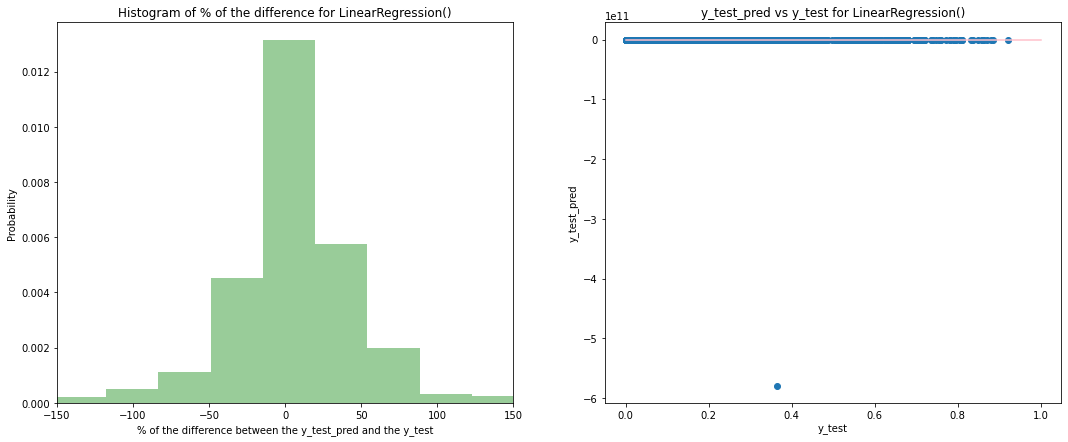

In [61]:
# The linear regression model results
lr_func(LinearRegression(), car_both, 0, False, 4000, False)

The linear regression model without tuning the hyperparameters shows an error.

Test set Accuracy R2: 0.749
Train set RMSE: 0.074
Test set RMSE: 0.070
Training set CV scores mean: 0.715
Training set CV scores: [0.67039629 0.73233076 0.74293732 0.68420959 0.7465313 ]
% of total revenue generated by the model vs the actual revenue: 0.49 %


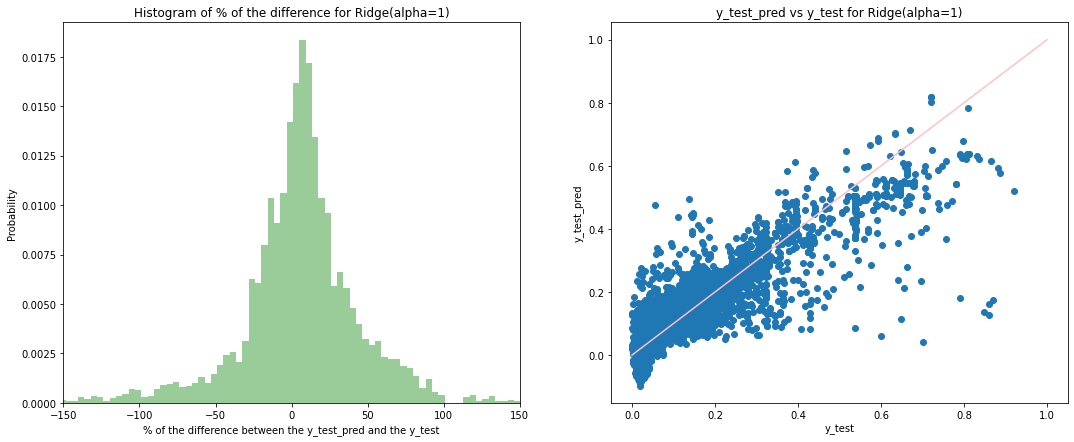

In [62]:
# The Ridge regression model results
lr_func(Ridge(alpha = 1), car_both, 0, False, 4000, False)

The Ridge model(alpha = 1) without tuning the hyperparameters shows a good accuracy(0.749) and a low root of mean squared error(0.070).

And the % of total revenue generated by the model vs the actual revenue is 0.49 %.

From the left figure of the % difference, we observe that the error distribution has a mean around zero and mainly located in the range (-100, 100). 

From the right figure of the test unit price vs the predition, there is significant contribution(with large number of observations) for the errors in the small test unit price region. This indicates that the current linear regression model doesn't represent the low test unit price features good enough. We will consider to include more categorical features in the following sections.

### 6.3 Linear regression with Recursive Feature Elimination(RFE)

#### 6.3.1 Finding main features based on the RFE

In [63]:
# Recursive feature elimination (RFE) with random forest

In [64]:
# Define a function to apply RFE with cross-validation
def RFE_func(X, y, min_fea):
    # Create the RFE object and rank each pixel
    clf_rf = RandomForestRegressor(n_estimators= 20, min_samples_leaf = 0.005)      
    rfe = RFE(estimator= clf_rf, n_features_to_select = min_fea, step=1)
    rfe = rfe.fit(X, y)
    print('Chosen best ' + str(min_fea) +' feature by rfe:',X.columns[rfe.support_])
#     print(rfe.ranking_)
    return X.columns[rfe.support_]

In [65]:
# Define a function to apply RFE with cross-validation
def RFECV_func(X, y, min_fea):
    # Create the RFECV object and rank each pixel
    clf_rf = RandomForestRegressor(n_estimators= 20, min_samples_leaf = 0.005)      
    rfe = RFECV(estimator= clf_rf, min_features_to_select = min_fea, step=1, cv = 5)
    rfe = rfe.fit(X, y)
    print('Chosen best ' + str(min_fea) +' feature by rfe:',X.columns[rfe.support_])
#     print(rfe.ranking_)
    return X.columns[rfe.support_]

In [66]:
# # Potential relevant categorical features which neglect the high cardinality categorical features, for instance 'Customer_Id' and 'car_nr', etc.
# cat_dummy = ['booking_to_delivery_date', 'mode_of_transport', 'cust_segment_name', 'type', 'item_class_l1', 
#              'item_class_l2', 'item_class_l3', 'colour', 'plant_city', 'plant_country_name', 'most_expensive_part_l1',
#              'most_expensive_part_l2', 'shipto_country', 'soldto_country']

# # Add MORE dummy variables
# num_cols_rfe = ['unit_price($000)', 'no_of_units', 'totol_spend', 'past_size', 'past_spend', 'transaction_period', 
#              'last_paid_price', 'delivery_period', 'booking_to_delivery_date', 
#                 'mode_of_transport', 'cust_segment_name', 'type', 'item_class_l1', 'item_class_l2', 'item_class_l3',
#                 'colour', 'plant_city', 'plant_country_name', 'most_expensive_part_l1', 'most_expensive_part_l2',
#                 'shipto_country', 'soldto_country']

In [67]:
# Potential relevant categorical features neglecting the high cardinality categorical features, for instance 'Customer_Id' and 'car_nr', etc.
cat_dummy = ['type', 'item_class_l1', 'item_class_l2', 'item_class_l3' , 'mode_of_transport', 'most_expensive_part_l1', 'most_expensive_part_l2', 'soldto_country']

# Add dummy variables
num_cols_rfe = ['unit_price($000)', 'no_of_units', 'totol_spend', 'past_size', 'past_spend', 'transaction_period', 
             'last_paid_price', 'delivery_period', 'type', 'item_class_l1', 'item_class_l2', 'item_class_l3', 
                'mode_of_transport', 'most_expensive_part_l1', 'most_expensive_part_l2', 'soldto_country']

In [68]:
car_rfe = car_no_out[num_cols_rfe]

In [69]:
# Applying the function to creat dummies
for x in cat_dummy:
    car_rfe = dummies(x , car_rfe)
car_rfe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16084 entries, 0 to 16722
Columns: 140 entries, unit_price($000) to soldto_country_Zambia
dtypes: float64(8), uint16(132)
memory usage: 5.8 MB


In [70]:
# Rescaling of the input features with MinMaxScaler
rescale(car_rfe)
# Check if the data is rescaled properly
car_rfe.describe()

unit_price($000)   no_of_units   totol_spend     past_size  \
count      16084.000000  16084.000000  16084.000000  16084.000000   
mean           0.154661      0.128641      0.090279      0.085666   
std            0.140080      0.170864      0.129789      0.099873   
min            0.000000      0.000000      0.000000      0.000000   
25%            0.063262      0.021415      0.015117      0.022533   
50%            0.125266      0.059513      0.039857      0.051374   
75%            0.178264      0.159988      0.109133      0.112663   
max            1.000000      1.000000      1.000000      1.000000   

         past_spend  transaction_period  last_paid_price  delivery_period  \
count  16084.000000        16084.000000     16084.000000     16084.000000   
mean       0.105196            0.611287         0.185993         0.240771   
std        0.125575            0.293113         0.167770         0.202527   
min        0.000000            0.000000         0.000000         0.000000   
25%        0.027687            0.369231         0.075448         0.104460   
50%        0.061962            0.662348         0.151668         0.178404   
75%        0.135308            0.874494         0.216660         0.390845   
max        1.000000            1.000000         1.000000         1.000000   

        type_manual  item_class_l1_Mid-range  ...  soldto_country_Morocco  \
count  16084.000000             16084.000000  ...            16084.000000   
mean       0.983711                 0.000062  ...                0.013989   
std        0.126590                 0.007885  ...                0.117449   
min        0.000000                 0.000000  ...                0.000000   
25%        1.000000                 0.000000  ...                0.000000   
50%        1.000000                 0.000000  ...                0.000000   
75%        1.000000                 0.000000  ...                0.000000   
max        1.000000                 1.000000  ...                1.000000   

       soldto_country_Mozambique  soldto_country_Namibia  \
count               16084.000000            16084.000000   
mean                    0.011440                0.003979   
std                     0.106347                0.062957   
min                     0.000000                0.000000   
25%                     0.000000                0.000000   
50%                     0.000000                0.000000   
75%                     0.000000                0.000000   
max                     1.000000                1.000000   

       soldto_country_Niger  soldto_country_Nigeria  soldto_country_Senegal  \
count          16084.000000            16084.000000            16084.000000   
mean               0.010818                0.026237                0.086297   
std                0.103450                0.159845                0.280811   
min                0.000000                0.000000                0.000000   
25%                0.000000                0.000000                0.000000   
50%                0.000000                0.000000                0.000000   
75%                0.000000                0.000000                0.000000   
max                1.000000                1.000000                1.000000   

       soldto_country_Somalia  soldto_country_South Africa  \
count            16084.000000                 16084.000000   
mean                 0.013554                     0.009140   
std                  0.115633                     0.095166   
min                  0.000000                     0.000000   
25%                  0.000000                     0.000000   
50%                  0.000000                     0.000000   
75%                  0.000000                     0.000000   
max                  1.000000                     1.000000   

       soldto_country_Sudan  soldto_country_Zambia  
count          16084.000000           16084.000000  
mean               0.001492               0.040662  
std                0.03860

In [71]:
# Make a copy to process the RFE
car_rfe_temp = car_rfe.copy(True)
# Dividing data into X and y variables
y = car_rfe_temp.pop('unit_price($000)')
X = car_rfe_temp

In [72]:
# Apply RFE to obtian certain number of dominated features
# The number of features are investigated and it is reasonable to set the selection below for the following process.
# col_rfe_50 = RFE_func(X, y, 50)

In [75]:
col_rfe_50 = ['no_of_units', 'totol_spend', 'past_size', 'past_spend',
       'transaction_period', 'last_paid_price', 'delivery_period',
       'type_manual', 'item_class_l1_Mid-range', 'item_class_l1_Premium',
       'item_class_l2_Aston Martin', 'item_class_l2_Bentley',
       'item_class_l2_Bugatti', 'item_class_l2_Koenigsegg',
       'item_class_l2_Lotus Cars', 'item_class_l2_McLaren Automotive',
       'item_class_l2_Pagani', 'item_class_l2_Rolls-Royce',
       'item_class_l2_W Motors', 'item_class_l3_Bentley',
       'item_class_l3_Ferrari', 'item_class_l3_Koenigsegg',
       'item_class_l3_Lamborghini1', 'item_class_l3_Lamborghini2',
       'item_class_l3_Lamborghini6', 'item_class_l3_W Motors1',
       'most_expensive_part_l1_cowl screen', 'most_expensive_part_l1_decklid',
       'most_expensive_part_l1_fascia', 'most_expensive_part_l1_fender',
       'most_expensive_part_l1_grille', 'most_expensive_part_l1_quarter panel',
       'most_expensive_part_l1_radiator', 'most_expensive_part_l1_rims',
       'most_expensive_part_l1_roof rack',
       'most_expensive_part_l1_trim package', 'most_expensive_part_l1_valance',
       'most_expensive_part_l2_bumper', 'most_expensive_part_l2_roof',
       'most_expensive_part_l2_video', 'most_expensive_part_l2_voltage',
       'most_expensive_part_l2_window seal', 'most_expensive_part_l2_windows',
       'most_expensive_part_l2_woofer', 'soldto_country_Benin',
       'soldto_country_Botswana', 'soldto_country_Burkina Faso',
       'soldto_country_Burundi', 'soldto_country_Gabon',
       'soldto_country_Kenya']

#### 6.3.2 Linear regression with the main features based on the RFE

In [76]:
col_rfe =list(col_rfe_50)
col_rfe.insert(0,'unit_price($000)')
car_rfe_min = car_rfe[col_rfe]

Test set Accuracy R2: -283446671171.448
Train set RMSE: 0.069
Test set RMSE: 74204.530
Training set CV scores mean: -6609400612014107648.000
Training set CV scores: [ 7.27920659e-01  7.62701200e-01 -3.30469929e+19 -1.01335023e+13
  7.79805010e-01]
% of total revenue generated by the model vs the actual revenue: -126232.23 %


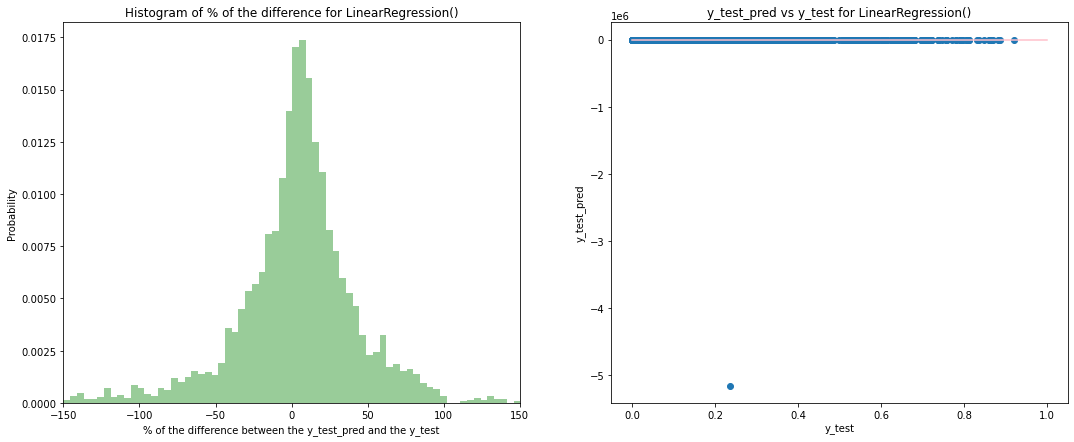

In [77]:
# The linear regression model results
lr_func(LinearRegression(), car_rfe_min, 0, False, 4000, False)

The linear regression model(weight_k = 0) without tuning the hyperparameters shows an error.

Test set Accuracy R2: 0.782
Train set RMSE: 0.069
Test set RMSE: 0.065
Training set CV scores mean: 0.756
Training set CV scores: [0.72793088 0.76269661 0.7745457  0.73536018 0.77986589]
% of total revenue generated by the model vs the actual revenue: -0.47 %


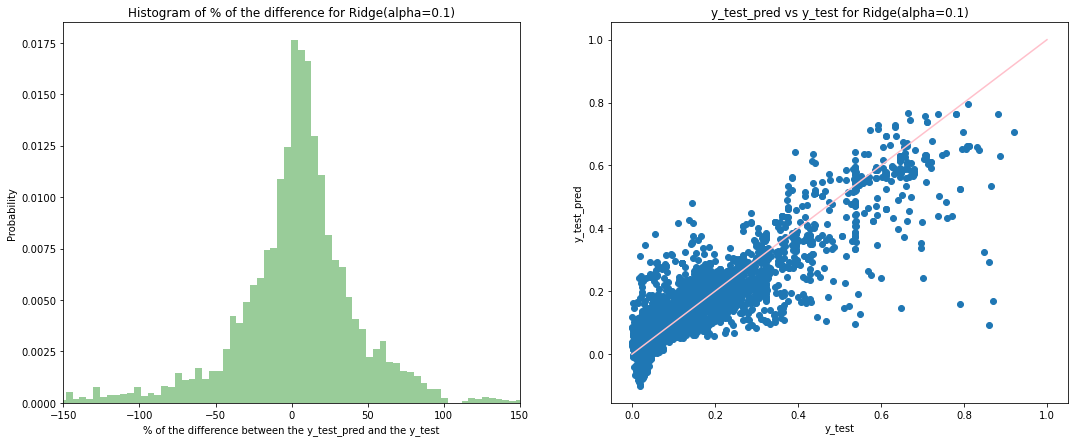

In [78]:
# The Ridge regression model results
lr_func(Ridge(alpha = 0.1), car_rfe_min, 0.5, False, 4000, False)

The Ridge model(alpha = 1) without tuning the hyperparameters shows a good accuracy(0.785) and a low root of mean squared error(0.065) which is slightly better than the previoius Ridge models.

And the % of total revenue generated by the model vs the actual revenue is -0.87 %.

From the left figure of the % difference, we observe that the error distribution has a mean around zero and mainly located in the range (-100, 100). 

From the right figure of the test unit price vs the predition, there is significant contribution(with large number of observations) for the errors in the small test unit price region. This indicates that the current Ridge model doesn't represent the low test unit price features good enough.

### 6.4 Decision tree regression

Because the previous Ridge model shows the there is significant contribution(with large number of observations) for the errors in the small test unit price region, the current Ridge model shows some limitations.

We apply the decision tree regression model to the data.

Test set Accuracy R2: 0.859
Train set RMSE: 0.050
Test set RMSE: 0.052
Training set CV scores mean: 0.827
Training set CV scores: [0.79764283 0.84607766 0.83676339 0.81712786 0.83877637]
% of total revenue generated by the model vs the actual revenue: 5.26 %


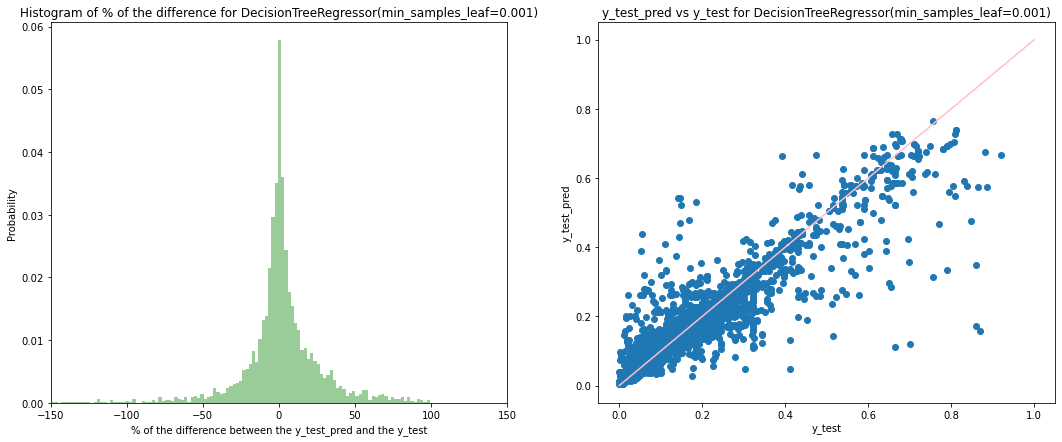

In [79]:
# The decision tree regression model results
lr_func(DecisionTreeRegressor(min_samples_leaf = 0.001), car_rfe_min, 0, False, 400, True)

The DecisionTreeRegressor(min_samples_leaf = 0.001) without tuning the hyperparameters shows an significant improvement in the accuracy(0.785) and a lower root of mean squared error(0.053) than the previous models.

And the % of total revenue generated by the model vs the actual revenue is 4.77 % that is much higher than the previous Ridge models and linear regression models.

From the left figure of the % difference, we observe that the error distribution has a mean around zero and mainly located in the range (-40, 40) that is smaller than the Ridge model (-100, 100). Besides, there is an significant amount of observations near zero that means the accuracy of these observations is very good.

From the right figure of the test unit price vs the predition, there is no significant contribution(with large number of observations) for the errors in the small test unit price region. This indicates that the performance of the decision tree model is better than the previous Ridge models and linear regression models.

## 7. Hyperparameters tuning

We have not process hyperparameters tuning in the previous process.

By tuning hyperparameters, we expect that the accuracy of our models would improve.

We will define a function to for the hyperparameters tuning process and apply hyperparameters tuning for linear regerssion model, Ridge model and Decistion tree regression model.

In [80]:
# Define a function for the following hyperparameters tuning process
def hyper_tuning(df, model, weight_k):
   
    np.random.seed(0)
    df_train, df_test = train_test_split(df, train_size = 0.7, test_size = 0.3, random_state = 10)
    # Dividing data into X and y variables
    y_train = df_train.pop('unit_price($000)')
    X_train = df_train
    y_test = df_test.pop('unit_price($000)')
    X_test = df_test
    # Adding a weight decaies expontentially based on the transaction period
    weight = X_train.transaction_period.array-1
    sample_weight = np.exp(weight_k * weight)
    # regression model
    lr = BaggingRegressor(base_estimator= model, n_estimators= 3, random_state= 10)
    lr.fit(X_train,y_train, sample_weight)
    y_train_pred = lr.predict(X_train)
    y_test_pred = lr.predict(X_test)
    y_test_pred = lr.predict(X_test)
    # Test set Accuracy R2
    R2 = lr.score(X_test,y_test)
    return R2

### 7.1 Hyperparameter tuning for linear regression model

For the linear regression model, there is only one hyperparameter: 'weight_k' which controls the exponential decay rate based on the transaction period.

In [81]:
# Define an objective function to be maximized.
def objective(trial):

    # Suggest values for the hyperparameters using a trial object.
    weight_k = trial.suggest_uniform('weight_k', 0, 2)
    df = car_rfe_min
    model = LinearRegression()
    
    R2 = hyper_tuning(df, model, weight_k)
    return R2

In [136]:
# Create a study object and optimize the objective function.
# Run the tuning for certain number of trials and present the best parameters.
study = optuna.create_study(direction= 'maximize')
study.optimize(objective, n_trials= 150)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2021-10-19 21:22:42,256] A new study created in memory with name: no-name-0c2ac54a-897e-4211-9c5e-1f88483dd267
[I 2021-10-19 21:22:42,314] Trial 0 finished with value: 0.6848160949257067 and parameters: {'leaf': 0.042883120221145564, 'weight_k': 2.92279444389526, 'max_fea': 20.166419925891496}. Best is trial 0 with value: 0.6848160949257067.
[I 2021-10-19 21:22:42,360] Trial 1 finished with value: 0.6463180493997616 and parameters: {'leaf': 0.04878315269840505, 'weight_k': 2.3231231557821235, 'max_fea': 10.14746759595317}. Best is trial 0 with value: 0.6848160949257067.
[I 2021-10-19 21:22:42,450] Trial 2 finished with value: 0.7035895608092397 and parameters: {'leaf': 0.02401909691122483, 'weight_k': 4.141390420435723, 'max_fea': 45.8606923355312}. Best is trial 2 with value: 0.7035895608092397.
[I 2021-10-19 21:22:42,545] Trial 3 finished with value: 0.8420092105659538 and parameters: {'leaf': 0.0008378393936226984, 'weight_k': 3.237200137805842, 'max_fea': 22.63965709498232}. Bes

[I 2021-10-19 21:22:46,388] Trial 33 finished with value: 0.8425985104983249 and parameters: {'leaf': 0.0008897810041184972, 'weight_k': 2.6199942766071653, 'max_fea': 33.886100959013675}. Best is trial 15 with value: 0.885534139178847.
[I 2021-10-19 21:22:46,515] Trial 34 finished with value: 0.8681638945734692 and parameters: {'leaf': 0.00044268357533186535, 'weight_k': 2.214814440793243, 'max_fea': 29.87721074725848}. Best is trial 15 with value: 0.885534139178847.
[I 2021-10-19 21:22:46,657] Trial 35 finished with value: 0.8420049102175318 and parameters: {'leaf': 0.0006578890440100004, 'weight_k': 2.989233045467367, 'max_fea': 38.27789863760849}. Best is trial 15 with value: 0.885534139178847.
[I 2021-10-19 21:22:46,732] Trial 36 finished with value: 0.8206219705832836 and parameters: {'leaf': 0.0009115851397633587, 'weight_k': 3.4649137760311146, 'max_fea': 10.684733049063986}. Best is trial 15 with value: 0.885534139178847.
[I 2021-10-19 21:22:46,824] Trial 37 finished with valu

[I 2021-10-19 21:22:51,286] Trial 66 finished with value: 0.8597837727741664 and parameters: {'leaf': 0.0004601904820909212, 'weight_k': 2.8350155130755796, 'max_fea': 44.5762057173273}. Best is trial 64 with value: 0.8897101653274109.
[I 2021-10-19 21:22:51,452] Trial 67 finished with value: 0.8523665650264621 and parameters: {'leaf': 0.000647824966697314, 'weight_k': 2.6885888327204723, 'max_fea': 49.80050175555603}. Best is trial 64 with value: 0.8897101653274109.
[I 2021-10-19 21:22:51,603] Trial 68 finished with value: 0.8721686181917515 and parameters: {'leaf': 0.0003978350564558842, 'weight_k': 1.6240184856144528, 'max_fea': 38.776020101908856}. Best is trial 64 with value: 0.8897101653274109.
[I 2021-10-19 21:22:51,773] Trial 69 finished with value: 0.8853575345666235 and parameters: {'leaf': 0.0003028988679937128, 'weight_k': 1.901804656987158, 'max_fea': 45.88742370924542}. Best is trial 64 with value: 0.8897101653274109.
[I 2021-10-19 21:22:51,919] Trial 70 finished with val

[I 2021-10-19 21:22:56,548] Trial 99 finished with value: 0.7752086138714703 and parameters: {'leaf': 0.007355507575283797, 'weight_k': 1.9708716334355214, 'max_fea': 41.709699080453674}. Best is trial 64 with value: 0.8897101653274109.
[I 2021-10-19 21:22:56,722] Trial 100 finished with value: 0.8833624792288077 and parameters: {'leaf': 0.0003350191331843627, 'weight_k': 1.7006389289310078, 'max_fea': 43.61764910469752}. Best is trial 64 with value: 0.8897101653274109.
[I 2021-10-19 21:22:56,895] Trial 101 finished with value: 0.8741422391403048 and parameters: {'leaf': 0.00037555022855507243, 'weight_k': 1.7700266670674136, 'max_fea': 45.71088778766537}. Best is trial 64 with value: 0.8897101653274109.
[I 2021-10-19 21:22:57,074] Trial 102 finished with value: 0.8860887059902809 and parameters: {'leaf': 0.00033251164625451384, 'weight_k': 2.1374718393445473, 'max_fea': 47.21505474163447}. Best is trial 64 with value: 0.8897101653274109.
[I 2021-10-19 21:22:57,180] Trial 103 finished 

[I 2021-10-19 21:23:01,444] Trial 132 finished with value: 0.8696874444205634 and parameters: {'leaf': 0.00037368250538013907, 'weight_k': 1.7155219762305913, 'max_fea': 38.31147939393368}. Best is trial 123 with value: 0.8909448434150279.
[I 2021-10-19 21:23:01,600] Trial 133 finished with value: 0.8887287551690591 and parameters: {'leaf': 0.0003515686810248516, 'weight_k': 1.5907253769019483, 'max_fea': 40.065140023655616}. Best is trial 123 with value: 0.8909448434150279.
[I 2021-10-19 21:23:01,744] Trial 134 finished with value: 0.8884581677715373 and parameters: {'leaf': 0.0004893388251986499, 'weight_k': 1.4507726735884412, 'max_fea': 39.11311860936032}. Best is trial 123 with value: 0.8909448434150279.
[I 2021-10-19 21:23:01,892] Trial 135 finished with value: 0.8690602868573484 and parameters: {'leaf': 0.0004908412753142936, 'weight_k': 1.4285018540906413, 'max_fea': 40.435542477160006}. Best is trial 123 with value: 0.8909448434150279.
[I 2021-10-19 21:23:02,041] Trial 136 fin

Number of finished trials: 150
Best trial: {'leaf': 0.00042281840175584305, 'weight_k': 1.7834658112643833, 'max_fea': 39.43768657038293}


Without regularization, the linear regression model shows some error.

In [83]:
# Plot_optimization_historY: shows the scores from all trials as well as the best score so far at each point.
# optuna.visualization.plot_optimization_history(study)

In [84]:
# Plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
# optuna.visualization.plot_parallel_coordinate(study)

In [85]:
# '''plot_slice: shows the evolution of the search. You can see where in the hyperparameter space your search
# went and which parts of the space were explored more.'''
# optuna.visualization.plot_slice(study)

In [86]:
# Visualize empirical distribution function
# optuna.visualization.plot_edf(study)

{'weight_k': 0.14312579812181325}
Test set Accuracy R2: 0.782
Train set RMSE: 0.069
Test set RMSE: 0.065
Training set CV scores mean: -6609400612014107648.000
Training set CV scores: [ 7.27920659e-01  7.62701200e-01 -3.30469929e+19 -1.01335023e+13
  7.79805010e-01]
% of total revenue generated by the model vs the actual revenue: 0.00 %


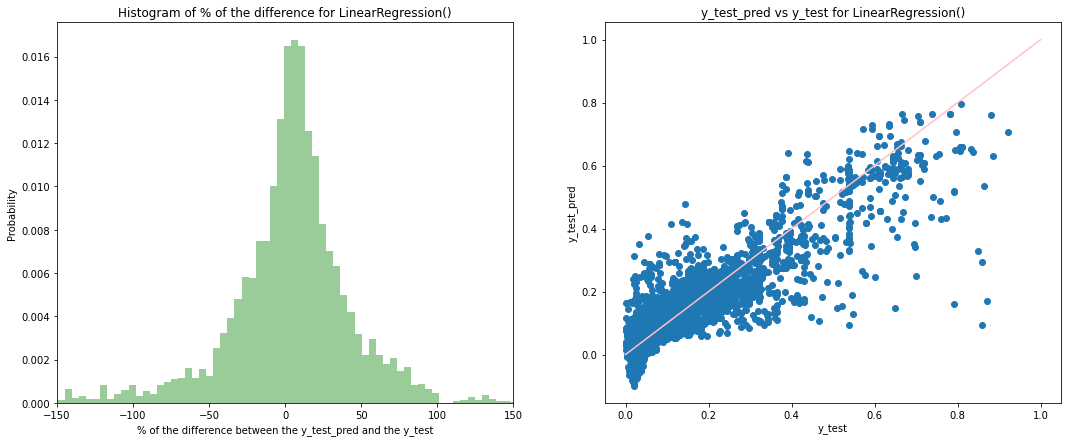

In [87]:
print(study.best_params)
weight_k_opt = study.best_params['weight_k']
lr_func(LinearRegression(), car_rfe_min, weight_k_opt, False, 4000, False)

Without regularization, we observe some error shown by the linear regression model.

### 7.2 Hyperparameter tuning for Ridge model

For the Ridge model, there are two hyperparameters: 

1). 'weight_k' controls the exponential decay rate based on the transaction period.

2). 'alpha' is the parameter for the regularization.

In [88]:
# Define an objective function to be maximized.
def objective(trial):
    # Suggest values for the hyperparameters using a trial object.
    weight_k = trial.suggest_uniform('weight_k', 0, 5)
    alpha = trial.suggest_loguniform('alpha', 1e-5, 1e2)
    df = car_rfe_min
    model = Ridge(alpha= alpha)
    
    R2 = hyper_tuning(df, model, weight_k)
    return R2

In [89]:
# Create a study object and optimize the objective function
# Run the tuning for certain number of trials and present the best parameters.
study = optuna.create_study(direction= 'maximize')
study.optimize(objective, n_trials= 100)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2021-10-19 21:14:28,445] A new study created in memory with name: no-name-3a6edae9-7e93-4c2d-9cce-7d332e8abccb
[I 2021-10-19 21:14:28,493] Trial 0 finished with value: 0.7633217296275946 and parameters: {'weight_k': 4.124357292823217, 'alpha': 20.835091341792104}. Best is trial 0 with value: 0.7633217296275946.
[I 2021-10-19 21:14:28,543] Trial 1 finished with value: 0.781543587192657 and parameters: {'weight_k': 1.5350581939475112, 'alpha': 0.08906306524219419}. Best is trial 1 with value: 0.781543587192657.
[I 2021-10-19 21:14:28,590] Trial 2 finished with value: 0.7815441883279258 and parameters: {'weight_k': 1.4039610543586978, 'alpha': 0.6117799577356144}. Best is trial 2 with value: 0.7815441883279258.
[I 2021-10-19 21:14:28,858] Trial 3 finished with value: 0.7815741186324225 and parameters: {'weight_k': 1.5309749318698385, 'alpha': 0.00013274405347780442}. Best is trial 3 with value: 0.7815741186324225.
[I 2021-10-19 21:14:28,906] Trial 4 finished with value: 0.7421458522439

[I 2021-10-19 21:14:30,671] Trial 37 finished with value: 0.7824142679639995 and parameters: {'weight_k': 0.2743127116066649, 'alpha': 0.007423506201534716}. Best is trial 11 with value: 0.7824157427561491.
[I 2021-10-19 21:14:30,726] Trial 38 finished with value: 0.7809632488471979 and parameters: {'weight_k': 1.7328204537847816, 'alpha': 1.1470019972647347}. Best is trial 11 with value: 0.7824157427561491.
[I 2021-10-19 21:14:30,785] Trial 39 finished with value: 0.7818260460288287 and parameters: {'weight_k': 1.300358488141446, 'alpha': 0.005096720710586334}. Best is trial 11 with value: 0.7824157427561491.
[I 2021-10-19 21:14:30,840] Trial 40 finished with value: 0.7756003114541009 and parameters: {'weight_k': 2.0846426494669186, 'alpha': 10.790067875061006}. Best is trial 11 with value: 0.7824157427561491.
[I 2021-10-19 21:14:30,895] Trial 41 finished with value: 0.7824129297516854 and parameters: {'weight_k': 0.3289416134707739, 'alpha': 3.0909633002402284e-05}. Best is trial 11 

[I 2021-10-19 21:14:32,766] Trial 75 finished with value: 0.7824158634073928 and parameters: {'weight_k': 0.24475768200938505, 'alpha': 1.6106677289839746e-05}. Best is trial 75 with value: 0.7824158634073928.
[I 2021-10-19 21:14:32,823] Trial 76 finished with value: 0.7823983542266697 and parameters: {'weight_k': 0.42750497881348104, 'alpha': 1.4355625624774638e-05}. Best is trial 75 with value: 0.7824158634073928.
[I 2021-10-19 21:14:32,880] Trial 77 finished with value: 0.7822643103693113 and parameters: {'weight_k': 0.7647319023216588, 'alpha': 4.435570301309055e-05}. Best is trial 75 with value: 0.7824158634073928.
[I 2021-10-19 21:14:32,936] Trial 78 finished with value: 0.782415484744958 and parameters: {'weight_k': 0.28771884692945604, 'alpha': 1.6595793835358308e-05}. Best is trial 75 with value: 0.7824158634073928.
[I 2021-10-19 21:14:32,990] Trial 79 finished with value: 0.7814936083303007 and parameters: {'weight_k': 1.5990023788543302, 'alpha': 1.721277329551824e-05}. Best

Number of finished trials: 100
Best trial: {'weight_k': 0.2727239251387131, 'alpha': 3.908931537849329e-05}


In [90]:
# Plot_optimization_historY: shows the scores from all trials as well as the best score so far at each point.
optuna.visualization.plot_optimization_history(study)

In [91]:
#plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
optuna.visualization.plot_parallel_coordinate(study)

In [92]:
'''plot_slice: shows the evolution of the search. You can see where in the hyperparameter space your search
went and which parts of the space were explored more.'''
optuna.visualization.plot_slice(study)

In [93]:
#plot_contour: plots parameter interactions on an interactive chart. You can choose which hyperparameters you would like to explore.
optuna.visualization.plot_contour(study, params=['alpha', 'weight_k'])

In [94]:
#Visualize parameter importances.
optuna.visualization.plot_param_importances(study)

The importance of hyperparameters: the importance of 'alpha' is much higher than the importance of 'weight_k'.

In [95]:
#Visualize empirical distribution function
optuna.visualization.plot_edf(study)

{'weight_k': 0.2727239251387131, 'alpha': 3.908931537849329e-05}
Test set Accuracy R2: 0.782
Train set RMSE: 0.069
Test set RMSE: 0.065
Training set CV scores mean: 0.756
Training set CV scores: [0.72791696 0.76266523 0.77455148 0.73537207 0.77983977]
% of total revenue generated by the model vs the actual revenue: -0.17 %


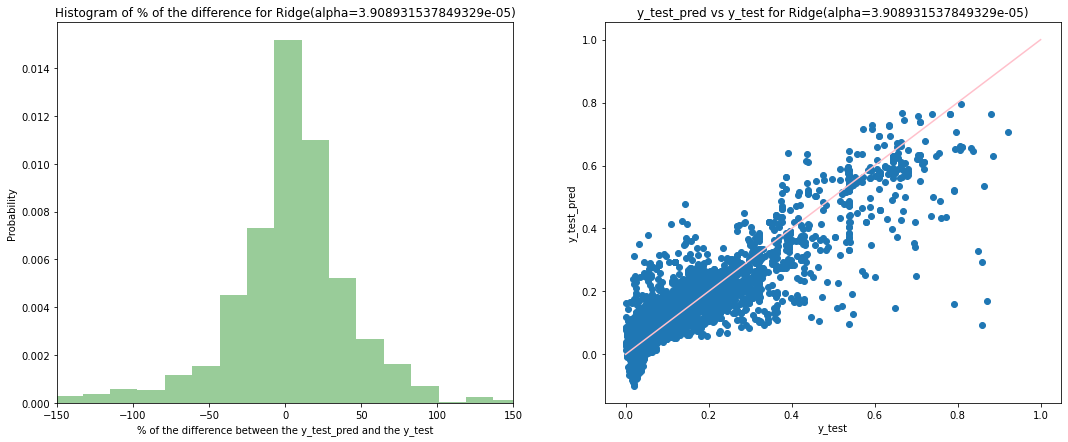

In [96]:
# Apply the best hyperparameters to the Ridge model and presents the results.
print(study.best_params)
alpha_opt = study.best_params['alpha']
weight_k_opt = study.best_params['weight_k']
lr_func(Ridge(alpha = alpha_opt), car_rfe_min, weight_k_opt, False, 8000, False)

### 7.3 Hyperparameter tuning for decision tree regression model

#### 7.3.1 Hyperparameter tuning using RandomizedSearchCV

In [97]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Setup the hyperparameter grid
leaf_space = np.arange(0.0001, 0.01, 0.00001)
param_grid = {'min_samples_leaf': leaf_space}

# Instantiate a decision tree regression model
dtr = DecisionTreeRegressor()

# Instantiate the GridSearchCV object:
df = car_rfe_min
model = RandomizedSearchCV(dtr, param_grid, cv= 5)
weight_k = 0

np.random.seed(0)
df_train, df_test = train_test_split(df, train_size = 0.7, test_size = 0.3, random_state = 10)
# Dividing data into X and y variables
y_train = df_train.pop('unit_price($000)')
X_train = df_train
y_test = df_test.pop('unit_price($000)')
X_test = df_test
# Adding a weight decaies expontentially based on the transaction period
weight = X_train.transaction_period.array-1
sample_weight = np.exp(weight_k * weight)
# regression model
lr = model
lr.fit(X_train,y_train, sample_weight)
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
y_test_pred = lr.predict(X_test)

print('Test set Accuracy R2: {:.3f}'.format(lr.score(X_test,y_test)))
# Training set MSE
print('Train set RMSE: {:.3f}'.format(np.sqrt(MSE(y_train, y_train_pred))))
# Test set MSE
print('Test set RMSE: {:.3f}'.format(np.sqrt(MSE(y_test, y_test_pred))))

# Print the tuned parameter and score
print("Tuned Decision Tree Regression Parameters: min_samples_leaf: {:.5f}".format(lr.best_params_['min_samples_leaf']))
print("Best score is {:.3f}".format(lr.best_score_))

Test set Accuracy R2: 0.842
Train set RMSE: 0.038
Test set RMSE: 0.055
Tuned Decision Tree Regression Parameters: min_samples_leaf: 0.00041
Best score is 0.821


#### 7.3.2 Hyperparameter tuning using Optuna

In [169]:
# Define an objective function to be maximized.
def objective(trial):

    # Suggest values for the hyperparameters using a trial object.
#     split = trial.suggest_loguniform('split', 1e-4, 1e-2)
    leaf = trial.suggest_loguniform('leaf', 3e-4, 1e-1)
    weight_k = trial.suggest_uniform('weight_k', 0, 5)
#     max_fea = trial.suggest_uniform('max_fea', 10, 45)
    
    df = car_rfe_min
    model = DecisionTreeRegressor(min_samples_leaf = leaf, max_features = 40)
    
    R2 = hyper_tuning(df, model, weight_k)
    return R2

In [170]:
# Create a study object and optimize the objective function.
study = optuna.create_study(direction= 'maximize')
study.optimize(objective, n_trials= 100)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2021-10-19 21:32:05,918] A new study created in memory with name: no-name-40ebe86a-d781-4f7b-8330-92002df41f91
[I 2021-10-19 21:32:06,073] Trial 0 finished with value: 0.8519147392729973 and parameters: {'leaf': 0.00030251108956620996, 'weight_k': 4.185471308020939}. Best is trial 0 with value: 0.8519147392729973.
[I 2021-10-19 21:32:06,204] Trial 1 finished with value: 0.834057076630526 and parameters: {'leaf': 0.00179064155970962, 'weight_k': 3.4516877469978784}. Best is trial 0 with value: 0.8519147392729973.
[I 2021-10-19 21:32:06,348] Trial 2 finished with value: 0.868115453061517 and parameters: {'leaf': 0.00040951912388070453, 'weight_k': 0.00079963312579312}. Best is trial 2 with value: 0.868115453061517.
[I 2021-10-19 21:32:06,422] Trial 3 finished with value: 0.6872797905575012 and parameters: {'leaf': 0.038640008212791184, 'weight_k': 1.4604330800719156}. Best is trial 2 with value: 0.868115453061517.
[I 2021-10-19 21:32:06,546] Trial 4 finished with value: 0.841544907312

[I 2021-10-19 21:32:11,123] Trial 37 finished with value: 0.8552199566058931 and parameters: {'leaf': 0.0012659392781814091, 'weight_k': 2.9829701782895137}. Best is trial 32 with value: 0.8862865590360351.
[I 2021-10-19 21:32:11,264] Trial 38 finished with value: 0.862378313252218 and parameters: {'leaf': 0.0007087408629712808, 'weight_k': 0.022225867388780296}. Best is trial 32 with value: 0.8862865590360351.
[I 2021-10-19 21:32:11,351] Trial 39 finished with value: 0.6945889112520856 and parameters: {'leaf': 0.024176528952803304, 'weight_k': 1.2919329112325626}. Best is trial 32 with value: 0.8862865590360351.
[I 2021-10-19 21:32:11,421] Trial 40 finished with value: 0.576054829734882 and parameters: {'leaf': 0.08461179865975518, 'weight_k': 1.5568877108582138}. Best is trial 32 with value: 0.8862865590360351.
[I 2021-10-19 21:32:11,569] Trial 41 finished with value: 0.8713804659460872 and parameters: {'leaf': 0.00040178981372182, 'weight_k': 0.8156232355812458}. Best is trial 32 wi

[I 2021-10-19 21:32:16,583] Trial 75 finished with value: 0.8705115286557026 and parameters: {'leaf': 0.00042388325742282937, 'weight_k': 2.7171788183965164}. Best is trial 65 with value: 0.88842819273143.
[I 2021-10-19 21:32:16,732] Trial 76 finished with value: 0.8581677989783372 and parameters: {'leaf': 0.0005366446807530319, 'weight_k': 2.2795677922242095}. Best is trial 65 with value: 0.88842819273143.
[I 2021-10-19 21:32:16,892] Trial 77 finished with value: 0.8800773681200164 and parameters: {'leaf': 0.0003485425617037387, 'weight_k': 2.0178490972532}. Best is trial 65 with value: 0.88842819273143.
[I 2021-10-19 21:32:16,968] Trial 78 finished with value: 0.668936523416406 and parameters: {'leaf': 0.05037465807571621, 'weight_k': 3.3169270145987135}. Best is trial 65 with value: 0.88842819273143.
[I 2021-10-19 21:32:17,056] Trial 79 finished with value: 0.7392007597859471 and parameters: {'leaf': 0.020775919245743065, 'weight_k': 1.4134229678049643}. Best is trial 65 with value:

Number of finished trials: 100
Best trial: {'leaf': 0.00035126960485381534, 'weight_k': 1.8424521462047099}


In [171]:
# Best trial: {'leaf': 0.00035126960485381534, 'weight_k': 1.8424521462047099}

In [172]:
# Plot_optimization_historY: shows the scores from all trials as well as the best score so far at each point.
optuna.visualization.plot_optimization_history(study)

In [173]:
#plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
optuna.visualization.plot_parallel_coordinate(study)

In [174]:
'''plot_slice: shows the evolution of the search. You can see where in the hyperparameter space your search
went and which parts of the space were explored more.'''
optuna.visualization.plot_slice(study)

In [175]:
#plot_contour: plots parameter interactions on an interactive chart. You can choose which hyperparameters you would like to explore.
optuna.visualization.plot_contour(study, params=['leaf', 'weight_k'])

In [176]:
#Visualize parameter importances.
optuna.visualization.plot_param_importances(study)

In [177]:
#Visualize empirical distribution function
optuna.visualization.plot_edf(study)

{'leaf': 0.00035126960485381534, 'weight_k': 1.8424521462047099}
Test set Accuracy R2: 0.887
Train set RMSE: 0.038
Test set RMSE: 0.047
Training set CV scores mean: 0.844
Training set CV scores: [0.81134396 0.87914536 0.8362477  0.84667142 0.84906175]
% of total revenue generated by the model vs the actual revenue: 4.61 %


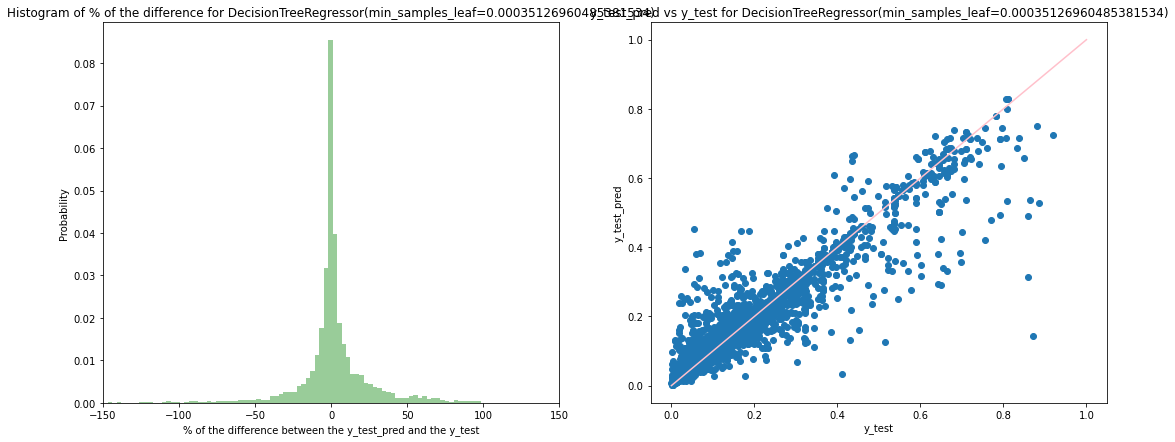

In [178]:
leaf_opt = study.best_params['leaf']
weight_k_opt = study.best_params['weight_k']
# max_fea_opt = study.best_params['max_fea']
print(study.best_params)
lr_func(DecisionTreeRegressor(min_samples_leaf = leaf_opt), car_rfe_min, weight_k_opt, False , 400, True)

The DecisionTreeRegressor with tuned hyperparameters shows an significant improvement in the accuracy(0.887) and a lower root of mean squared error(0.047) than the previous Ridge models and linear regression models.

The cross-validation shows an mean of R2 scores of 0.844 that is very good.

And the % of total revenue generated by the model vs the actual revenue is 4.61 % that is much higher than the previous Ridge models and linear regression models.

From the left figure of the % difference, we observe that the error distribution has a mean around zero and mainly located in the range (-30, 30) that is smaller than the Ridge model (-100, 100). Besides, there is an significant amount of observations near zero that means the accuracy of these observations is very good.

From the right figure of the test unit price vs the predition, there is no significant contribution(with large number of observations) for the errors in the small test unit price region. This indicates that the performance of the decision tree model is better than the previous Ridge models and linear regression models.

## 8. Conclusion

We have explored the linear regression models, Ridge models and decision tree regression model for the project.

The EDA, visualization and correlation analysis indicate the features' importances.

The RFE is useful to select the dominated features automatically.

The hyperparameters tuning process is important to find the optimal hyperparameters.

The comparison of the results shows that the decision tree regression model presents the best R2 accuracy score of 0.887 (with the mean cross-validation score of 0.844) and the root of mean squared error 0.047(with the train set RMSE of 0.038). And the % of total revenue generated by the model vs the actual revenue is 4.61 %.

The Ridge model shows the secondary R2 accuracy score of 0.782 and the root of mean squared error of 0.065. And the % of total revenue generated by the model vs the actual revenue is -0.16%.